# Final Project - The Rumos Bank Marketing Campaign


Depois do vosso sucesso no primeiro projecto no The Rumos Bank, surge um novo projecto ainda mais empolgante!

A equipa de marketing quer lançar uma nova campanha cujo objetivo é convencer os clientes a abrir depósitos a prazo.

Até agora a estratégia era ligar ao máximo número de pessoas, de forma indiscriminada, e tentar vender-lhe o produto. No entanto essa abordagem, para além de gastar mais recursos porque implica ter várias pessoas a ligar a todos os clientes, também é incomóda para alguns clientes que não gostam de ser incomodados com esse tipo de chamadas. Feitas as contas, chegou-se à conclusão que:

    - Por cada cliente identificado como um bom candidado, e é alvo da campanha mas não adere ao depósito a prazo, o banco tem um custo de 500euros.
    - Por cada cliente que é identificado como mau candidado, e como tal não é alvo da campanha mas na verdade era um bom candidado e iria aderir, o banco tem um custo de 2000euros.
    
Com base nesta informação, conseguem ajudar a equipa de marketing criando um modelo que seleccione os melhores candidatos para serem alvos da campanha, de forma a reduzir custos?


**O dataset contêm informação sobre todos os clientes que foram alvo da campanha:**

    1 - age
    2 - job : type of job
    3 - marital : marital status
    4 - education
    5 - default: has credit in default?
    6 - housing: has housing loan?
    7 - loan: has personal loan?
    8 - pdays: number of days that passed by after the client was last contacted from a previous campaign
    9 - previous: number of contacts performed before this campaign and for this client
    10 - poutcome: outcome of the previous marketing campaign
    11 - emp.var.rate: employment variation rate - quarterly indicator
    12 - cons.price.idx: consumer price index - monthly indicator
    13 - cons.conf.idx: consumer confidence index - monthly indicator
    14 - euribor3m: euribor 3 month rate - daily indicator
    15 - nr.employed: number of employees - quarterly indicator

**Output:**
    
    y: has the client subscribed a term deposit?
    
   

#### Perguntas:

    1. Quantas features estão disponíveis? Quantos clientes?
    2. Quantos clientes têm no dataset que efectivamente aderiram ao depósito a prazo? E quantos não o fizeram?
    3. Quais são as features mais relevantes para decidir se um cliente tem mais propensão para aderir ao depósito a prazo?
    4. Qual o algoritmo que levou aos melhores resultados?
    5. Qual/Quais as métricas de avaliação que usaram para comparar a performance dos vários modelos? Porquê?
    6. Qual é o custo que o banco tem sem nenhum modelo?
    7. Qual o custo que o banco passa a ter com o vosso modelo?
    
    
    
    

---

# Importação de Bibliotecas

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,LabelEncoder
from collections import defaultdict
import time
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
import pandas as pd

Caso necesite correr o presente notebook no Google Colab, inicializar a variavel use_google_colab a true.

In [117]:
use_google_colab = False

Importação da fonte de dados

In [118]:
if use_google_colab:
  
  import pandas as pd
  from google.colab import drive
  drive.mount('/content/drive')

  # Run this cell to mount your Google Drive.
  if not os.environ.get("RUMOS_ML_DATA_PATH"):
    from google.colab import drive
    drive.mount('/content/drive')

    root_path = '/content/drive/My Drive/Fundamentos_ML_Dados/'
  else:
    root_path = os.environ.get("RUMOS_ML_DATA_PATH")
    
  data_path = os.path.join(root_path, 'bank_marketing_campaign.csv')
else:
    datapath = 'bank_marketing_campaign.csv'

df = pd.read_csv(datapath)

# Constantes

---

Definição de a constantes utilizadas no presente código

In [119]:
false_positive_cost = 500
false_negative_cost = 2000
seed = 42

# 1. Quantas features estão disponíveis? Quantos clientes?

---

Apresentar aleatóriamente 10 registos para analisar formato de dados.

In [120]:
df.sample(10)

,age,job,marital,education,default,housing,loan,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
34175,57,blue-collar,married,basic.6y,unknown,no,no,999,0,nonexistent,-1.8,92.893,-46.2,1.281,5099.1,no
7397,40,services,married,high.school,no,no,yes,999,0,nonexistent,1.1,93.994,-36.4,4.864,5191.0,yes
2132,57,retired,single,high.school,no,unknown,unknown,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
35357,33,entrepreneur,married,university.degree,no,yes,no,999,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1,no
3896,52,blue-collar,married,basic.4y,no,no,yes,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
8089,47,technician,divorced,high.school,no,yes,no,999,0,nonexistent,1.4,94.465,-41.8,4.865,5228.1,no
6807,51,admin.,divorced,university.degree,no,unknown,unknown,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
14686,33,blue-collar,divorced,basic.9y,unknown,no,no,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,yes
25471,48,admin.,single,professional.course,no,no,no,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,no
31119,46,services,divorced,basic.9y,no,yes,no,999,1,failure,-1.8,92.893,-46.2,1.334,5099.1,no


Obter as dimensões do DataFrame e apresentar o número de linhas (observações) e colunas (variáveis)

In [121]:
df.shape

(41188, 16)

Obter algumas estatísticas descritivas do DataFrame

In [122]:
df.describe()

,age,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Verificar existência de valores nulos por coluna

In [123]:
# Calculate the sum of null values for each column
print(df.isnull().sum())


age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


Consultar tipos de dados das variaveis

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   pdays           41188 non-null  int64  
 8   previous        41188 non-null  int64  
 9   poutcome        41188 non-null  object 
 10  emp.var.rate    41188 non-null  float64
 11  cons.price.idx  41188 non-null  float64
 12  cons.conf.idx   41188 non-null  float64
 13  euribor3m       41188 non-null  float64
 14  nr.employed     41188 non-null  float64
 15  y               41188 non-null  object 
dtypes: float64(5), int64(3), object(8)
memory usage: 5.0+ MB


In [125]:
print(f"nº de clientes {df.shape[0]}")
print(f"nº de features {df.shape[1]-1}, não foi cosiderado a coluna y, pois é a variavel target")

nº de clientes 41188
nº de features 15, não foi cosiderado a coluna y, pois é a variavel target


# 2. Quantos clientes têm no dataset que efectivamente aderiram ao depósito a prazo? E quantos não o fizeram?

---

In [126]:
df["y"].value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

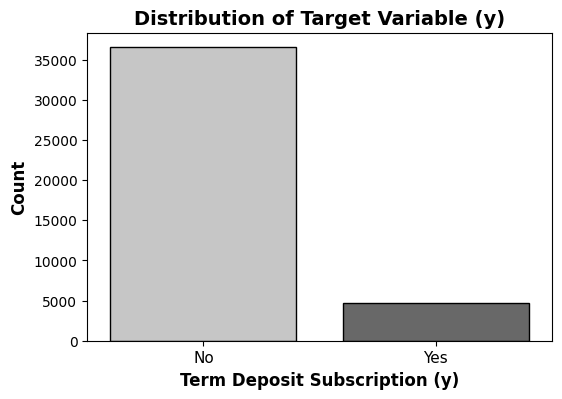

In [127]:
# Contagem da variável alvo
target_counts = df["y"].value_counts()

# Criar a gráfico
plt.figure(figsize=(6, 4))

# Criar gráfico de barras com Seaborn 
sns.barplot(x=target_counts.index, y=target_counts.values, palette="Greys", edgecolor="black",hue=target_counts.index)

# Definir rótulos e título
plt.xlabel("Term Deposit Subscription (y)", fontsize=12, fontweight="bold")
plt.ylabel("Count", fontsize=12, fontweight="bold")
plt.title("Distribution of Target Variable (y)", fontsize=14, fontweight="bold")

# Melhorar a legibilidade dos rótulos do eixo X
plt.xticks(ticks=[0, 1], labels=["No", "Yes"], fontsize=11)

# Exibir o gráfico
plt.show()


In [128]:
print(f"Nº de CLientes subscrevereram o deposito a prazo: {len(df[df['y'] == 'yes'])}.")
print(f"Nº de CLientes que não subscrevereram o deposito a prazo: {len(df[df['y'] == 'no'])}.")


Nº de CLientes subscrevereram o deposito a prazo: 4640.
Nº de CLientes que não subscrevereram o deposito a prazo: 36548.


O facto das classes estarem desbalanceadas, é um indicador a ter cuidado na escolha das métricas de avaliação dos modelos de previsão.

---

# 3. Quais são as features mais relevantes para decidir se um cliente tem mais propensão para aderir ao depósito a prazo?

---

Para identificar as features mais relevantes, sem descartar as variáveis categóricas, é realizada, num primeiro momento, uma análise exploratória, e de seguida de um pré-processamento, garantindo que sejam devidamente consideradas na presente análise.

No código abaixo são identificadas as variaveis categóricas presentes no DataFrame df. Em seguida, para cada uma dessas variaveis, calcular o número de valores únicos, armazenando essa informação num dicionário onde as chaves são os nomes das colunas e os valores representam a contagem de categorias distintas. Para facilitar a visualização, esses dados são organizados num DataFrame, onde cada linha corresponde a uma variável categórica e indica quantos valores únicos ela possui

In [129]:
# Selecionar colunas categóricas
categorical_cols = df.select_dtypes(include=["object"]).columns

# Contar valores únicos para cada variável categórica
unique_values_counts = {col: df[col].nunique() for col in categorical_cols}

# Criar DataFrame para exibição
categorical_df = pd.DataFrame(list(unique_values_counts.items()), columns=["Categorical Feature", "Unique Values"])
categorical_df


,Categorical Feature,Unique Values
0,job,12
1,marital,4
2,education,8
3,default,3
4,housing,3
5,loan,3
6,poutcome,3
7,y,2


No código abaixo são listados todos os valores únicos presentes em cada variável categórica do DataFrame df. Num primeiro momento é criado um dicionário onde as chaves são os nomes das colunas categóricas e os valores correspondem a listas contendo os diferentes valores únicos de cada uma dessas colunas.

In [130]:
# Criar um dicionário com os valores únicos de cada variável categórica
unique_values_dict = {col: df[col].unique().tolist() for col in categorical_cols}

# Criar um DataFrame com os valores apurados em cima
unique_cat_values_df = pd.DataFrame([(col, val) for col, values in unique_values_dict.items() for val in values],
                                columns=["Feature", "Unique Values"])

unique_cat_values_df

,Feature,Unique Values
0,job,housemaid
1,job,services
2,job,admin.
3,job,blue-collar
4,job,technician
5,job,retired
6,job,management
7,job,unemployed
8,job,self-employed
9,job,unknown


In [131]:
# Copiar o DataFrame para evitar alterações no original
df_transformed = df.copy()

A variável `Marital` e `pOutcome`, por terem um número reduzido de valores únicos, foram transformadas através de one-hot encoding. No caso da variavel `Marital` uma pequena parte dos registos estava classificada como "Unknown", pelo que foi aplicada imputação da moda, substituindo esses valores pelo estado civil mais frequente.

Abaixo é apresentado uma função que gera um histograma para analise de cada uma das variáveis categóricas.

In [132]:
def plot_histogram(df, column, title, color="silver", figsize=(6,4)):
    """
    Gera um histograma de contagem para uma variável categórica.

    Parâmetros:
    - df: DataFrame contendo os dados.
    - column: Nome da coluna a ser plotada.
    - title: Título do gráfico (default: "Distribuição da Variável").
    - color: Cor das barras (default: "silver").
    - figsize: Tamanho da figura (default: (6,4)).

    Retorna:
    - Exibe o histograma.
    """
    plt.figure(figsize=figsize)
    df[column].value_counts().plot(kind="bar", color=color, edgecolor="black")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()


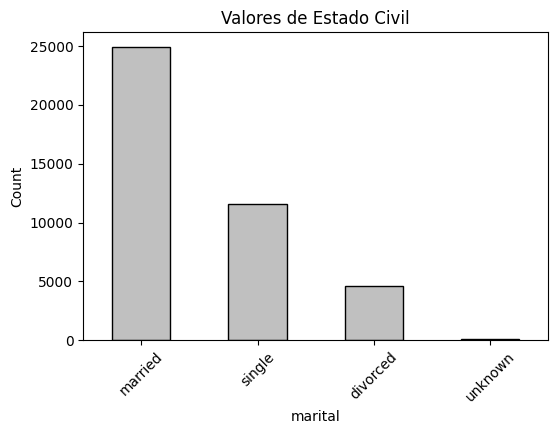

In [133]:
plot_histogram(df, "marital", title="Valores de Estado Civil")

Susbistuição dos valores desconhecidos da variavel Marital, pelo moda da variavel

In [134]:
# Calcular a moda e substituir "unknown"
mode_value = df["marital"].mode()[0]  # Pega o valor mais frequente
df_transformed["marital"] = df["marital"].replace("unknown", mode_value)

Em baixo temos a transformação das variaveis `marital` e `poutcome` em valor numérico através da técnica de One Hot Encoding.

In [135]:
# Inicializar o OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)
columns_ohe = ["marital","poutcome"]

# Ajustar o encoder e transformar os dados
one_hot_encoded = ohe.fit_transform(df_transformed[columns_ohe])
one_hot_columns = ohe.get_feature_names_out(columns_ohe)  # Corrigido

# Criar um DataFrame com os resultados do OHE
ohe_df = pd.DataFrame(one_hot_encoded, columns=one_hot_columns, index=df_transformed.index)

# Concatenar o resultado ao DataFrame original
df_transformed = pd.concat([df_transformed, ohe_df], axis=1)

# Remover a coluna original
df_transformed.drop(columns=columns_ohe, inplace=True)

# Exibir 15 linhas aleatórias do DataFrame atualizado para verificar o resultado
df_transformed.sample(15)

,age,job,education,default,housing,loan,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_nonexistent,poutcome_success
26405,32,technician,university.degree,no,unknown,unknown,999,1,-0.1,93.200,-42.0,4.076,5195.8,no,0.0,0.0,1.0,1.0,0.0,0.0
24204,51,blue-collar,high.school,no,no,yes,999,0,-0.1,93.200,-42.0,4.191,5195.8,no,0.0,1.0,0.0,0.0,1.0,0.0
34064,41,blue-collar,basic.4y,no,yes,no,999,0,-1.8,92.893,-46.2,1.281,5099.1,no,0.0,1.0,0.0,0.0,1.0,0.0
11677,56,technician,basic.9y,no,yes,no,999,0,1.4,94.465,-41.8,4.959,5228.1,no,1.0,0.0,0.0,0.0,1.0,0.0
8169,58,retired,basic.4y,no,yes,no,999,0,1.4,94.465,-41.8,4.864,5228.1,no,0.0,1.0,0.0,0.0,1.0,0.0
36461,31,management,university.degree,no,yes,no,999,0,-2.9,92.963,-40.8,1.262,5076.2,yes,0.0,1.0,0.0,0.0,1.0,0.0
34636,36,blue-collar,basic.6y,no,yes,yes,999,1,-1.8,92.893,-46.2,1.266,5099.1,no,0.0,1.0,0.0,1.0,0.0,0.0
16060,27,admin.,basic.9y,no,yes,yes,999,0,1.4,93.918,-42.7,4.961,5228.1,no,0.0,0.0,1.0,0.0,1.0,0.0
3317,24,student,high.school,no,no,no,999,0,1.1,93.994,-36.4,4.860,5191.0,no,0.0,0.0,1.0,0.0,1.0,0.0
36886,56,self-employed,university.degree,no,yes,no,999,0,-2.9,92.963,-40.8,1.235,5076.2,no,0.0,1.0,0.0,0.0,1.0,0.0


A variável `education` representa diferentes níveis de escolaridade que seguem uma ordem natural. Para preservar essa hierarquia, foi aplicada a técnica de Ordinal Encoding, convertendo as categorias em valores numéricos conforme uma ordem predefinida. Primeiro, definiu-se a sequência dos níveis de escolaridade, começando por "illiterate" e terminando em "university.degree". O valor "unknown" foi mantido e posicionado logo acima de "illiterate" na hierarquia, isto porque interepreto que não sabendo será superior do que o cenário que não tem qualquer tipo de literatura. Em seguida, utilizou-se o OrdinalEncoder do Scikit-Learn, configurado para atribuir valores numéricos de acordo com essa ordem. Adicionalmente, foi definida a opção handle_unknown="use_encoded_value" com unknown_value=-1, assegurando que qualquer valor inesperado seja representado por -1 em vez de causar um erro.

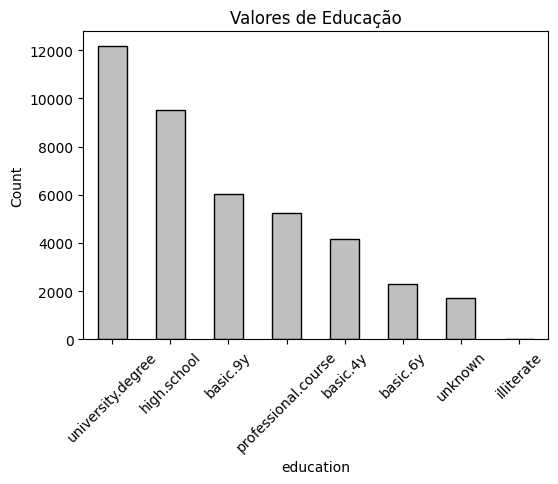

In [136]:
# Criar um histograma para a variável "education"
plot_histogram(df, "education", title="Valores de Educação")

Transformação da variavel  `education` em valor numérico através da tecnica de Ordinal Encoding 

In [137]:
# Aplicar Ordinal Encoding em 'education' conforme a ordem especificada
education_order = ["illiterate","unknown","basic.4y", "basic.6y", "basic.9y", "high.school", "professional.course", "university.degree"]
ordinal_encoder = OrdinalEncoder(categories=[education_order], handle_unknown="use_encoded_value", unknown_value=-1)
df_transformed["education"] = ordinal_encoder.fit_transform(df_transformed[["education"]])


Existem algumas variaveis booleanas (`housing,default e loan`), os valores destas variaveis  `yes` and `no` foram convertidos para valores numericos 0 e  1. E os valores Unknown foram substituidos pela moda.

A Função abaixo,  transforma variaveis booleanas em numericas, e os valores unknown são  subsituidos pela moda.

In [138]:
def preprocess_binary_col_num(df, col):
    """
    Função para transformar variaveis booleanas em numericas, valores unknow subsituidos pela moda.

    Parâmetros:
    - df (pd.DataFrame): DataFrame contendo a coluna a ser transformada.
    - col (str): Nome da coluna a ser transformada.

    Retorna:
    - pd.DataFrame: DataFrame transformado com "unknown" substituído pela moda e valores categóricos convertidos em numéricos.
    """

    if col in df.columns:
        # Calcular a moda da variável
        mode_value = df[col].mode()[0]

        # Substituir "unknown" pela moda
        df[col] = df[col].replace("unknown", mode_value)

        # Converter valores categóricos em numéricos
        df[col] = df[col].map({'yes': 1, 'no': 0}).astype(int)

    return df


 Abaixo é gerado um histograma para as variáveis "default,loan e house, e de seguida transformado os valores booleanos dessas variaveis para valores numéricos

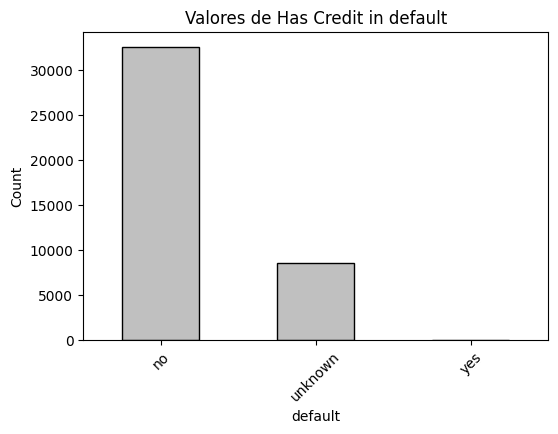

In [139]:
# Criar um histograma para a variável "default"
plot_histogram(df, "default", title="Valores de Has Credit in default")

In [140]:
df_transformed = preprocess_binary_col_num(df_transformed, 'default')
df_transformed['default'].unique().tolist()

[0, 1]

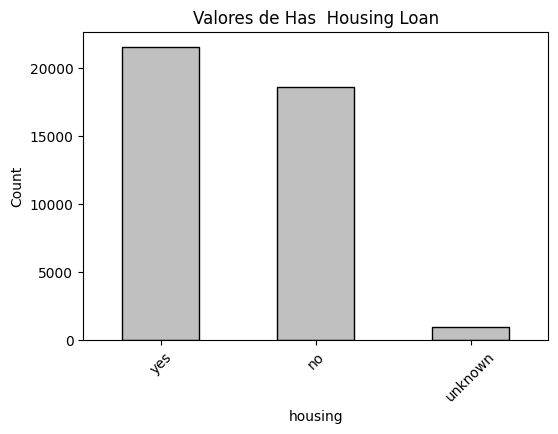

In [141]:
# Criar um histograma para a variável "housing"
plot_histogram(df, "housing", title="Valores de Has  Housing Loan")

In [142]:
df_transformed = preprocess_binary_col_num(df_transformed, 'housing')
df_transformed['housing'].unique().tolist()

[0, 1]

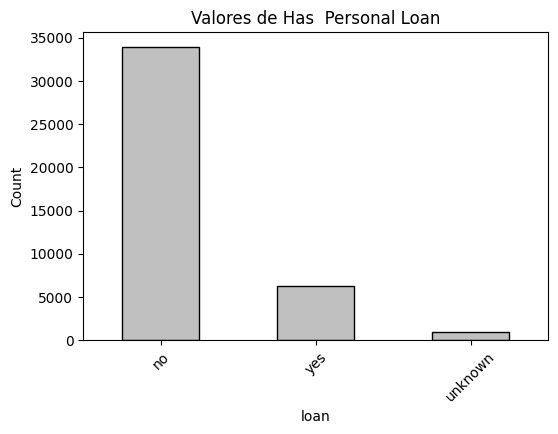

In [143]:
# Criar um histograma para a variável "loan"
plot_histogram(df, "loan", title="Valores de Has  Personal Loan")

In [144]:
df_transformed = preprocess_binary_col_num(df_transformed, 'loan')
df_transformed['loan'].unique().tolist()

[0, 1]

Na variável `output`, os valores "yes" e "no" foram substituídos por valores numéricos, respetivamente 1 e 0.

In [145]:
# transform output boolean to numeric 1 and 0
df_transformed['y'] = df_transformed['y'].map({'yes': 1, 'no': 0}).astype(int)

As restantes variaveis categóricas foi aplicado transformação label encoding.

In [146]:
# Aplicar Label Encoding nas restantes variáveis categóricas
label_encoders = {}
for col in df_transformed.select_dtypes(include=["object"]).columns:
      le = LabelEncoder()
      df_transformed[col] = le.fit_transform(df_transformed[col])
      label_encoders[col] = le

Apresentação de um sample de 5 registos aleatório do dataset resultado das transformações acima referidas

In [147]:
df_transformed.sample(5)

,age,job,education,default,housing,loan,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_nonexistent,poutcome_success
16882,35,1,1.0,0,1,0,999,0,1.4,93.918,-42.7,4.962,5228.1,0,0.0,1.0,0.0,0.0,1.0,0.0
24258,42,3,7.0,0,1,0,999,0,-0.1,93.200,-42.0,4.191,5195.8,0,0.0,1.0,0.0,0.0,1.0,0.0
21797,32,7,5.0,0,0,0,999,0,1.4,93.444,-36.1,4.964,5228.1,0,0.0,1.0,0.0,0.0,1.0,0.0
800,47,1,2.0,0,1,0,999,0,1.1,93.994,-36.4,4.856,5191.0,0,0.0,0.0,1.0,0.0,1.0,0.0
16880,43,9,6.0,0,1,0,999,0,1.4,93.918,-42.7,4.962,5228.1,0,0.0,1.0,0.0,0.0,1.0,0.0


---

Tendo terminado o préprocessamento de dados no passo anterior, o código abaixo  tem como objetivo identificar as variáveis mais importantes para a previsão do modelo, utilizando um Random Forest Classifier. O processo inicia-se com a criação e o treino do modelo, onde um RandomForestClassifier com 100 árvores de decisão é ajustado aos dados de treino (X_train e y_train).

Após o treino, calcula-se a importância das features com base na métrica Mean Decrease in Impurity (MDI), que avalia o impacto de cada variável na redução da impureza ao longo das divisões das árvores. Para aumentar a robustez da análise, é também calculado o desvio padrão da importância das features entre todas as árvores da floresta, refletindo a variabilidade da relevância de cada variável dentro do modelo.

Os resultados são armazenados num DataFrame, onde cada linha corresponde a uma variável e contém três colunas principais:


*   Nome da variável.
*   Importance – Grau de influência da variável no modelo.
*   Std – Desvio padrão da importância da variável ao longo das árvores do Random Forest.

No final as variáveis são ordenadas por ordem decrescente de importância. Além disso, é calculada a importância acumulada, que permite visualizar a percentagem da capacidade preditiva explicada pelas variáveis mais relevantes.

A função split_data tem como objetivo dividir um conjunto de dados num conjunto de treino e num conjunto de teste, permitindo ainda a opção de reduzir o tamanho do conjunto de treino através de amostragem.

Inicialmente, a função recebe um dataframe contendo os dados e o nome da coluna correspondente à variável alvo. O utilizador pode definir a proporção dos dados a serem usados para teste, sendo o valor padrão de 20%. Além disso, é possível especificar uma semente (random_state) para garantir que a divisão dos dados seja reprodutível em diferentes execuções que no inicio do presente notebook foi preenchida com o valor 42.

Após a separação inicial, caso a opção de amostragem esteja ativada, o conjunto de treino é reduzido para uma fração do seu tamanho original. Por padrão, essa fração é de 100%, mas pode ser ajustada conforme necessário.
Em seguida, os dados são organizados separando as variáveis independentes (features) da variável dependente (alvo). As variáveis independentes do conjunto de treino são armazenadas em X_train, enquanto a variável alvo correspondente fica em y_train. O mesmo processo é aplicado ao conjunto de teste, resultando nas variáveis X_test e y_test.

Por fim, a função retorna os quatro subconjuntos preparados, prontos para serem utilizados na construção e avaliação de modelos de machine learning.

In [148]:
def split_data(df, target_column, test_size=0.2, seed=None,sample_fraction=1):
    """
    Divide os dados em conjuntos de treino e teste, com a opção de reduzir o tamanho do conjunto de treino.

    Parâmetros:
    df (DataFrame): DataFrame contendo os dados.
    target_column (str): Nome da coluna alvo (variável dependente).
    test_size (float, opcional): Proporção dos dados a serem usados como teste. Padrão é 0.2 (20%).
    seed (int, opcional): Semente para reprodutibilidade dos dados.
    sample_fraction (float, opcional): Fração do conjunto de treino a ser usada, Padrão é 1 (100%).

    Retorna:
    X_train, X_test, y_train, y_test (DataFrames/Series): Conjuntos de treino e teste.
    """
    # Divisão entre treino e teste
    train_set, test_set = train_test_split(df, test_size=test_size, random_state=seed)

    # Aplicação da amostragem caso seja necessário
    if sample_fraction < 1:
        train_set = train_set.sample(frac=sample_fraction, random_state=seed)

    # Separação das variáveis independentes e dependente
    X_train = train_set.drop(columns=[target_column])
    y_train = train_set[target_column]
    X_test = test_set.drop(columns=[target_column])
    y_test = test_set[target_column]

    return X_train, X_test, y_train, y_test


In [149]:
X_train, X_test, y_train, y_test = split_data(df_transformed, target_column='y', test_size=0.2, seed=seed, sample_fraction=1)

In [150]:
# Criar e treinar o modelo
selected_model = RandomForestClassifier(n_estimators=100, random_state=42)
selected_model.fit(X_train, y_train)

# Calcular a importância das features e o desvio padrão entre as árvores
std = np.std([tree.feature_importances_ for tree in selected_model.estimators_], axis=0)

# Criar o DataFrame com os resultados
random_forest_importances = pd.DataFrame.from_dict({
    "Feature": X_train.columns,
    "Importance": selected_model.feature_importances_,
    "Std": std
}).sort_values(by="Importance", ascending=False)

# Calcular a importância acumulada
random_forest_importances["Cumulative Importance"] = random_forest_importances["Importance"].cumsum() / random_forest_importances["Importance"].sum()

random_forest_importances

,Feature,Importance,Std,Cumulative Importance
0,age,0.259975,0.015809,0.259975
11,euribor3m,0.211258,0.057931,0.471233
1,job,0.103107,0.007501,0.574341
2,education,0.084483,0.010923,0.658824
12,nr.employed,0.060109,0.060233,0.718933
6,pdays,0.045218,0.041654,0.764151
4,housing,0.037611,0.006267,0.801762
10,cons.conf.idx,0.033380,0.023100,0.835142
9,cons.price.idx,0.030214,0.017576,0.865356
8,emp.var.rate,0.028183,0.031081,0.893538


Os resultados da análise de importância das variáveis mostram que a idade é o fator mais relevante na decisão de um cliente aderir ao depósito a prazo.

A taxa Euribor a 3 meses surge como a segunda variável mais influente, o que indica que as condições do mercado financeiro desempenham um papel determinante. Por exemplo quando as taxas de juro estão elevadas, os clientes podem procurar alternativas de investimento mais rentáveis aos deposito a prazo

As variáveis tipo de profissão e nível de educação também se revelam fatores importantes. Certas profissões podem estar associadas a um maior poder de compra ou a um conhecimento financeiro mais sólido, aumentando assim a probabilidade de adesão ao depósito. Da mesma forma, o nível de escolaridade pode influenciar a familiaridade dos clientes com produtos bancários e investimentos.

Por fim, a quantidade de empregados no mercado também tem um impacto significativo, embora o seu elevado desvio padrão indique que a sua influência pode variar consoante o contexto. Este comportamento sugere que, em períodos de maior empregabilidade, os clientes podem sentir-se mais confiantes para investir, enquanto que, em tempos de incerteza, podem optar guardar o dinheiro.

A análise acumulada revela que as cinco variáveis mais importantes explicam cerca de 71% da decisão de adesão ao depósito. Tendo em consideração o custo computacional e a impossibilidade de incluir todas as variáveis no modelo, ao concentrar-se nestas variáveis, é possível construir um modelo preditivo sem recorrer a todas as variáveis disponíveis no conjunto de dados.

O gráfico abaixo apresenta a importância das variáveis utilizadas pelo modelo Random Forest, medida através da métrica Mean Decrease in Impurity (MDI).

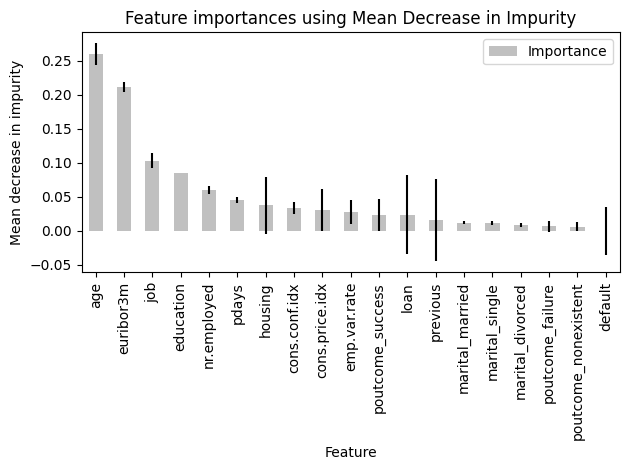

In [151]:
fig, ax = plt.subplots()
random_forest_importances.plot.bar(x="Feature", y="Importance",yerr=std, ax=ax,color="silver")
ax.set_title("Feature importances using Mean Decrease in Impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Após a análise acima, são selecionadas as 5 features mais importantes.

In [152]:
# Selecionar as 5 features mais importantes
top_5_features = random_forest_importances["Feature"].head(5).tolist()

# Criar um novo DataFrame com as top 5 features + variável target 'y'
df_reduced = df_transformed[top_5_features + ['y']]

In [153]:
df_reduced.sample(5)

,age,euribor3m,job,education,nr.employed,y
9978,45,4.959,2,5.0,5228.1,0
38841,39,0.714,0,5.0,5017.5,0
23689,29,4.962,0,7.0,5228.1,0
21489,39,4.963,0,7.0,5228.1,0
12574,34,4.960,1,2.0,5228.1,0


Após seleção das 5 featureas mais importantes é feito uma verificação se as variaveis escolhidas são idependentes.

Para identificar se todas as variaveis são independentes, nas células abaixo foi calculada a correlação entre as variaveis. 

<Axes: >

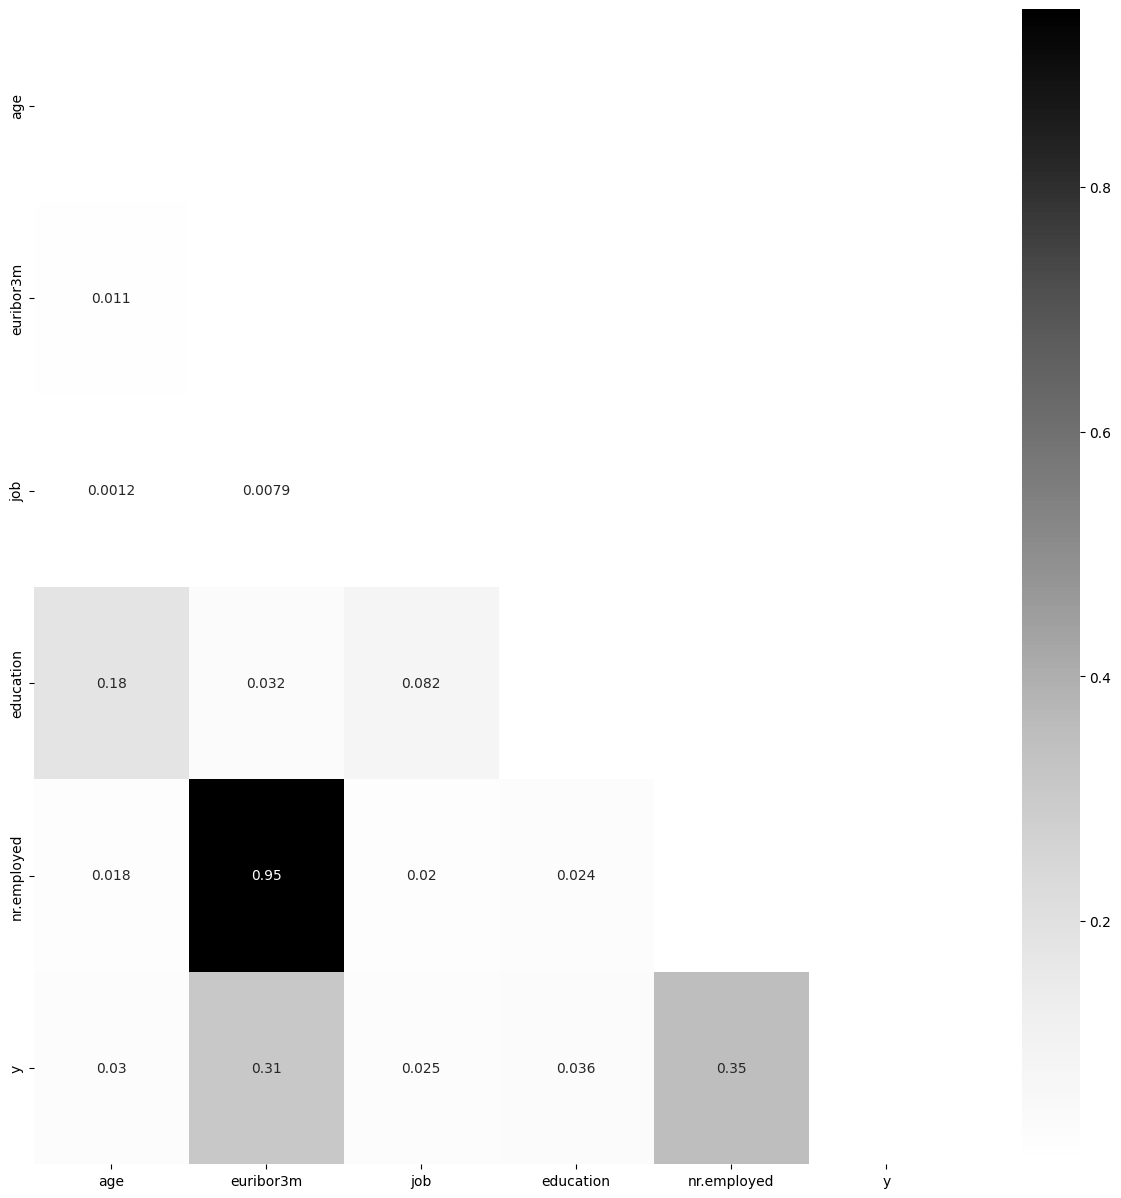

In [154]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_reduced.corr().abs(), annot=True, cmap = "Greys",ax=ax, mask = np.triu(np.ones_like(df_reduced.corr().abs(), dtype=bool)))

In [155]:
# Calcular a matriz de correlação absoluta
correlation_matrix = df_reduced.corr().abs()
# Criar uma máscara para evitar a repetição de valores na matriz
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
# Encontrar pares de variáveis com correlação >= 0.5
correlated_pairs = correlation_matrix.where(~mask).stack().reset_index()
correlated_pairs.columns = ["Feature1", "Feature2", "Correlation"]
high_corr_features = correlated_pairs[correlated_pairs["Correlation"] >= 0.70]
high_corr_features

,Feature1,Feature2,Correlation
7,nr.employed,euribor3m,0.945154


Confirma-se a existência de duas variáveis com um nível elevado de correlação. Nesse caso, optei por descartar uma delas, escolhendo aquela que teve menor importância na previsão do modelo, conforme determinado pelo Random Forest Classifier. O código abaixo identifica a variável menos relevante e remove-a do DataFrame final, garantindo que o conjunto de features utilizado no modelo seja composto por variaveis independentes.

In [156]:
# Se houver pares altamente correlacionados
if not high_corr_features.empty:
    print("Pares de variáveis com alta correlação (>=0.70):")
    print(high_corr_features)

    # Escolher a variável de menor importância e removê-la
    feature_to_remove = None
    for _, row in high_corr_features.iterrows():
        f1, f2 = row["Feature1"], row["Feature2"]
        # Comparar importâncias e remover a menor
        if random_forest_importances.loc[random_forest_importances["Feature"] == f1, "Importance"].values[0] < \
           random_forest_importances.loc[random_forest_importances["Feature"] == f2, "Importance"].values[0]:
            feature_to_remove = f1
        else:
            feature_to_remove = f2
        print(f"Removendo {feature_to_remove} devido à alta correlação com {f1 if feature_to_remove == f2 else f2}")

Pares de variáveis com alta correlação (>=0.70):
      Feature1   Feature2  Correlation
7  nr.employed  euribor3m     0.945154
Removendo nr.employed devido à alta correlação com euribor3m


O código abaixo remove a coluna identificada no passo anterior como tendo um elevado nível de correlação e menor relevância para o modelo. Em seguida, são apresentados 10 registos aleatórios do dataframe final que será utilizado nos modelos de previsão.

In [157]:
# Criar novo DataFrame apenas com variaveis independentes entre si.
df_reduced_final = df_reduced.drop(columns=[feature_to_remove])
df_reduced_final.sample(10)

,age,euribor3m,job,education,y
32283,35,1.313,7,5.0,0
7316,32,4.860,7,5.0,0
38175,71,0.754,5,2.0,1
25318,42,4.153,2,7.0,0
6287,42,4.857,9,5.0,0
38419,42,0.735,1,6.0,1
31922,40,1.327,0,4.0,0
13543,32,4.963,1,4.0,0
7886,24,4.865,7,5.0,0
22872,30,4.965,2,7.0,0


# 4. Qual o algoritmo que levou aos melhores resultados?

---

A escolha dos algoritmos foi feita com base na necessidade de encontrar um equilíbrio entre capacidade preditiva, e eficiência computacional. 
Dado que o objetivo é prever a adesão dos clientes a um depósito a prazo, selecionámos modelos de classificação, incluindo Random Forest, Decision Tree, Support Vector Machine (SVM), K-Nearest Neighbors (KNN), Regressão Logística e Redes Neuronais Artificiais (MLPClassifier). Cada um destes algoritmos apresentam vantagens e desafios específicos, tornando fundamental a sua avaliação cruzada/comparativa .

Para garantir a escolha do modelo mais eficaz, adotámos um processo híbrido de otimização de hiperparâmetros, combinando GridSearchCV e RandomizedSearchCV. O GridSearchCV foi utilizado para modelos onde o espaço de busca dos hiperparâmetros era relativamente reduzido e onde era importante testar todas as combinações possíveis, garantindo a obtenção da melhor configuração dentro de um conjunto pré-definido. No entanto, este método pode ser computacionalmente dispendioso, especialmente para modelos com múltiplos hiperparâmetros ajustáveis. Por essa razão, optou-se por complementar a abordagem com RandomizedSearchCV, que permite um outro tipo de exploração,  mais eficiente do espaço de hiperparâmetros.

O código abaixo chama função split_data para dividir um conjunto de dados tratado no ponto anterior num conjunto de treino e num conjunto de teste

In [158]:
X_train, X_test, y_train, y_test = split_data(df_reduced, target_column='y', test_size=0.2, seed=seed, sample_fraction=1)

Para garantir um código mais estruturado, modular e reutilizável, foram desenvolvidas várias funções de suporte que auxiliam na execução das diferentes etapas do processo de avaliação dos modelos. Estas funções permitem reduzir a repetição de código, aumentar a legibilidade e facilitar a manutenção, tornando o fluxo de trabalho mais eficiente.

Abaixo, cada uma das funções criadas será descrita detalhadamente, explicando o seu propósito.

A função train_models_with_gridsearch foi desenvolvida para aplicar o treino e otimização de múltiplos modelos de machine learning, utilizando o método GridSearchCV de forma a encontrar os melhores hiperparâmetros. Além de realizar o ajuste dos modelos, a função regista o tempo de execução de cada treino, permitindo uma análise da eficiência computacional de cada algoritmo.

O processo inicia-se com a iteração sobre a lista models_and_params, onde cada item contém o nome do modelo, o classificador correspondente e um dicionário de hiperparâmetros a serem testados. Para cada modelo, a função mede o tempo total de treino, executa o GridSearchCV com validação cruzada (cv), e armazena os resultados numa lista denominada grid_search_results. Paralelamente, o tempo de execução de cada modelo é registado num dicionário dentro da lista resource_usage, permitindo comparações entre os diferentes algoritmos em termos de custo computacional.

O retorno da função é composto por duas listas: a primeira, grid_search_results, contém os modelos treinados com os melhores hiperparâmetros encontrados, enquanto a segunda, resource_usage, regista o tempo de treino de cada modelo, facilitando a análise da eficiência dos algoritmos.

In [159]:
def train_models_with_gridsearch2(models_and_params, X_train, y_train, X_test, y_test, cv=5):
    """
    Treina múltiplos modelos usando GridSearchCV, regista o tempo de execução e guarda os melhores resultados.

    Parâmetros:
    - models_and_params: Lista contendo (nome_do_modelo, classificador, hiperparâmetros).
    - X_train: Conjunto de treino (features).
    - y_train: Conjunto de treino (labels).
    - X_test: Conjunto de teste (features).
    - y_test: Conjunto de teste (labels).
    - cv: Número de folds para cross-validation (default = 5).

    Retorna:
    - grid_search_results: Lista com os resultados de GridSearchCV para cada modelo.
    - resource_usage: Lista de dicionários contendo o tempo de treino de cada modelo.
    - grid_search_results_overall: m dicionário com os resultados de todos os modelos e o melhor modelo encontrado.
    """
    grid_search_results = []
    resource_usage = []
    results = []

    best_model_name = None
    best_roc_auc = 0

    for model_str, clf, params in models_and_params:
        print(f"Treinando modelo: {model_str}...")

        # Medir tempo de treino
        start_time = time.time()
        grid_search_result = GridSearchCV(clf, params, cv=cv).fit(X_train, y_train)
        end_time = time.time()
        elapsed_time = end_time - start_time

        # Guardar resultado
        grid_search_results.append(grid_search_result)
        resource_usage.append({
            "model": model_str,
            "training_time": elapsed_time
        })

        # Obter o melhor modelo encontrado
        best_estimator = grid_search_result.best_estimator_

        #Se o modelo suporta predict_proba(), ele retorna a probabilidade da classe positiva
        if hasattr(best_estimator, "predict_proba"):
            y_proba = best_estimator.predict_proba(X_test)[:, 1]
        else:
            y_scores = best_estimator.decision_function(X_test)
            y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())  # Normalização

        # Calcular roc_auc
        roc_auc = roc_auc_score(y_test, y_proba)

        # Guardar resultados em lista para DataFrame
        results.append({
            "Modelo": model_str,
            "ROC AUC": round(roc_auc, 4),
            "Tempo de Treino (s)": round(elapsed_time, 2)
        })

        # Verificar se este modelo é o melhor até agora
        if roc_auc > best_roc_auc:
            best_roc_auc = roc_auc
            best_model_name = model_str

        print(f"Modelo {model_str} concluído em {elapsed_time:.2f} segundos. ROC AUC: {roc_auc:.4f}\n")

    # Criar DataFrame com os resultados de todos os modelos
    df_grid_search_results = pd.DataFrame(results)

    # Criar DataFrame para armazenar o melhor modelo
    df_best_model = pd.DataFrame([{
        "model_name": best_model_name,
        "ROC AUC": best_roc_auc
    }])

    # Criar um dicionário contendo os resultados gerais
    grid_search_results_overall = {
        "df_grid_search_results": df_grid_search_results,
        "df_best_model": df_best_model
    }

    return grid_search_results, resource_usage, grid_search_results_overall

A função plot_roc_curves foi criada para gerar um gráfico da curva ROC (Receiver Operating Characteristic), permitindo a visualização comparativa do desempenho dos modelos treinados. A curva ROC é uma das principais métricas para avaliar classificadores binários, pois mede a capacidade do modelo em distinguir entre classes positivas e negativas em diferentes limiares de decisão.

In [160]:
def plot_roc_curves(models_and_params, grid_search_results, X_test, y_test):
    """
    Cria Gráfico plot para curva ROC para múltiplos modelos treinados.

    Parâmetros:
    - models_and_params: Lista contendo (nome_do_modelo, classificador, hiperparâmetros).
    - grid_search_results: Lista com os resultados do GridSearchCV para cada modelo.
    - X_test: Conjunto de features de teste.
    - y_test: Labels reais do conjunto de teste.

    Retorna:
    - Exibe um gráfico com as curvas ROC de todos os modelos.
    """
    fig, ax_roc = plt.subplots(1, 1, figsize=(12, 10))

    for i in range(len(models_and_params)):
        RocCurveDisplay.from_estimator(
            grid_search_results[i].best_estimator_,
            X_test,
            y_test,
            ax=ax_roc,
            name=models_and_params[i][0]
        )

    ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
    ax_roc.grid(linestyle="--")
    plt.legend()
    plt.show()


A função plot_training_time foi desenvolvida para gerar um gráfico de barras que apresenta o tempo de treino de cada modelo, permitindo uma análise comparativa da eficiência computacional dos diferentes algoritmos utilizados no projeto.

In [161]:
def plot_training_time(resource_usage):
    """
    Cria gráfico plot com o tempo de treino de cada modelo.

    Parâmetros:
    - resource_usage: Lista de dicionários contendo 'model' e 'training_time'.

    Retorna:
    - Exibe um gráfico de barras mostrando o tempo de treino por modelo.
    """
    # Criar DataFrame com os dados de consumo de recursos
    df_resource_usage = pd.DataFrame(resource_usage)

    # Criar a figura para o gráfico
    plt.figure(figsize=(10, 6))

    # Criar gráfico de barras para o tempo de treino por modelo
    ax = sns.barplot(x="model", y="training_time", data=df_resource_usage, color="grey")

    # Apresentar valores nas barras
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',  # Valor formatado com 2 casas decimais
                    (p.get_x() + p.get_width() / 2, p.get_height()),  # Posição do texto
                    ha='center', va='bottom',  # Alinhamento
                    fontsize=12, color='black', fontweight='bold')  # Estilo do texto

    # Configurar título e rótulos do gráfico
    plt.title("Tempo de Treino por Modelo")
    plt.ylabel("Tempo (segundos)")
    plt.xlabel("Modelo")
    plt.xticks(rotation=45)

    # Exibir o gráfico
    plt.show()

A função get_optimal_param_RandomizedSearchCV foi criada para tentar obter a melho definição de hiperparâmetros para um modelo de Machine Learning, utilizando o método RandomizedSearchCV. Este método permite explorar um conjunto aleatório de combinações de hiperparâmetros,com um reduzindo  custo computacional em vez de testar todos o tipo possiveis de hiperparametros

In [162]:
def get_optimal_param_RandomizedSearchCV(estimator, param_dist, X_train, y_train, cv=5, n_iter=10, scoring="roc_auc", random_state=42):
    """
    Otimiza os hiperparâmetros de um modelo usando RandomizedSearchCV.

    Parâmetros:
    - estimator: Modelo de machine learning a otimizar (ex.: KNeighborsClassifier()).
    - param_dist: Dicionário com os hiperparâmetros a testar.
    - X_train: Conjunto de treino (features).
    - y_train: Conjunto de treino (labels).
    - cv: Número de folds para cross-validation (default = 5).
    - n_iter: Número de combinações aleatórias de hiperparâmetros a testar (default = 10).
    - scoring: Métrica de avaliação para otimização (default = "roc_auc").
    - random_state: Semente aleatória para reprodutibilidade (default = 42).

    Retorna:
    - random_search: Objeto `RandomizedSearchCV` com os melhores hiperparâmetros encontrados.
    """
    # Criar RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist,
        n_iter=n_iter,  # Número de testes aleatórios
        scoring=scoring,  # Métrica de otimização
        cv=cv,
        n_jobs=-1,  # Usa todos os processadores disponíveis
        random_state=random_state
    )

    # Ajustar o modelo
    random_search.fit(X_train, y_train)

    # Mostrar os melhores hiperparâmetros encontrados
    print(f"Melhores hiperparâmetros para {estimator.__class__.__name__}: {random_search.best_params_}")

    return random_search

A função transform_dict_values foi criada para garantir que os valores de um dicionário sejam armazenados como listas, isto porque o método RandomizedSearchCV devolve apenas uma configuração de cada hiperparametro.

In [163]:
def transform_dict_values(param_dict, fields_to_convert=None):
    """
    Converte valores específicos de um dicionário para listas.
    Se nenhum campo for especificado, converte todos os campos.

    Parâmetros:
    - param_dict: Dicionário contendo os hiperparâmetros.
    - fields_to_convert: Lista de chaves cujos valores devem ser convertidos em listas.
                         Se None, todos os campos serão convertidos.

    Retorna:
    - Um dicionário onde os campos especificados (ou todos) foram convertidos para listas.
    """
    # Criar uma cópia do dicionário para não modificar o original
    updated_dict = param_dict.copy()

    # Se fields_to_convert não for especificado, aplicar a todos os campos
    if fields_to_convert is None:
        fields_to_convert = updated_dict.keys()

    # Converter os campos especificados para listas
    for field in fields_to_convert:
        if field in updated_dict and not isinstance(updated_dict[field], list):
            updated_dict[field] = [updated_dict[field]]

    return updated_dict

A função add_prefix_to_keys foi criada para adicionar um prefixo a todas as chaves de um dicionário, sendo especialmente útil em modelos que utilizam pipelines com pré-processamento, como normalização ou transformação de variáveis. Nestes casos, quando o modelo inclui etapas adicionais antes da fase de classificação, torna-se necessário concatenar "Classifier" às chaves dos hiperparâmetros, garantindo que os parâmetros sejam corretamente interpretados pelo GridSearchCV e RandomizedSearchCV.

In [164]:
def add_prefix_to_keys(dictionary, prefix):
    """
    Adiciona um prefixo a todas as chaves de um dicionário.

    Parâmetros:
    - dictionary: Dicionário original cujas chaves devem ser modificadas.
    - prefix: String a ser adicionada como prefixo às chaves.

    Retorna:
    - Novo dicionário com as chaves modificadas.
    """
    return {f"{prefix}{key}": value for key, value in dictionary.items()}


A função get_estimator_config foi criada para buscar e retornar a configuração completa de um modelo específico dentro de uma lista de modelos e parametros. Esta função desempenha um papel na gestão das configurações dos algoritmos que serão utilizados na validação cruzada entre diferentes modelos, garantindo que cada estimador seja identificado corretamente com os seus respetivos hiperparâmetros.

In [165]:
def get_estimator_config(models_and_params, estimator_name):
    """
    Retorna a configuração completa de um estimador específico, mantendo o formato original do tuplo.

    Parâmetros:
    - models_and_params: Lista de tuplas contendo (nome, modelo ou pipeline, hiperparâmetros).
    - estimator_name: Nome do estimador a ser buscado.

    Retorna:
    - Uma tupla (nome, modelo ou pipeline, hiperparâmetros) se o estimador for encontrado.
    - None se o nome do estimador não existir na lista.
    """
    for config in models_and_params:
        name, model, params = config
        if name == estimator_name:
            return config  # Retorna a tupla completa como está no dataset

    return None  # Retorna None se o estimador não for encontrado


#### Find best hiperparameters in SVM

O código abaixo apresentado define diferentes configurações do Suporte Vector Machine (SVM) juntamente com os seus hiperparâmetros para otimização, garantindo que o modelo seja ajustado para obter o melhor desempenho possível. Para tal, num primeiro momento foram criadas três variações do SVM (svm, svm2, svm3), cada uma com diferentes configurações de kernel, parâmetros C, e valores de gamma, com o objetivo de encontrar a combinação ideal para maximizar a capacidade preditiva do modelo.

A versão SVM utiliza um kernel linear, explorando diferentes valores de C, e capaz de deetar padões lineares nos dados. Por outro lado, as versões SVM2 e SVM3 utilizam o kernel RBF (Radial Basis Function), que é mais flexível e capaz de capturar padrões não lineares nos dados.

A versão SVM3, que incluía probability=True, permitia ao modelo gerar probabilidades das previsões, facilitando a sua utilização na curva ROC e na otimização de thresholds. No entanto, nos testes realizados, os resultados não foram satisfatórios, uma vez que o modelo apresentou baixa capacidade preditiva e um elevado consumo de recursos computacionais. *Dado o fraco desempenho, a terceira versão do SVM foi descartada, uma vez que não justificava o custo computacional associado aos seus resultados inferiores*

In [166]:
models_and_params = [
    (
        'svm',
        Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('Classifier', SVC(random_state = seed))
        ]),
        {
          "Classifier__C": [0.1, 1, 10],
          "Classifier__gamma": np.logspace(-9, 3, 10),
          "Classifier__kernel": ["linear"]
        }
    ),

    (
    'svm2',
    Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('Classifier', SVC(random_state=seed))  # Adicionado probability=True
    ]),
    {
      "Classifier__C": [0.1, 1, 10],
      "Classifier__gamma": np.logspace(-4, 1, 6),  # Valores mais práticos de gamma
      "Classifier__kernel": ["rbf"]
    }
   )

]

Código abaixo executa a função `train_models_with_gridsearch2`, que treina vários modelos definidos anteriormente utilizando a técnica de **Grid Search** para otimização dos hiperparâmetros. 



In [167]:
grid_search_results, resource_usage, grid_search_results_overall = train_models_with_gridsearch2(models_and_params, X_train, y_train, X_test, y_test)

Treinando modelo: svm...
Modelo svm concluído em 309.48 segundos. ROC AUC: 0.6786

Treinando modelo: svm2...
Modelo svm2 concluído em 597.51 segundos. ROC AUC: 0.6504



 Abaixo é executado a função `plot_roc_curves`, que gera gráfico das **Curvas ROC (Receiver Operating Characteristic)** para os modelos treinados. Através da representação desta métrica conseguimos  avaliar o desempenho dos modelos de classificação binária, permitindo visualizar a relação entre a **taxa de verdadeiros positivos ** e a **taxa de falsos positivos**.


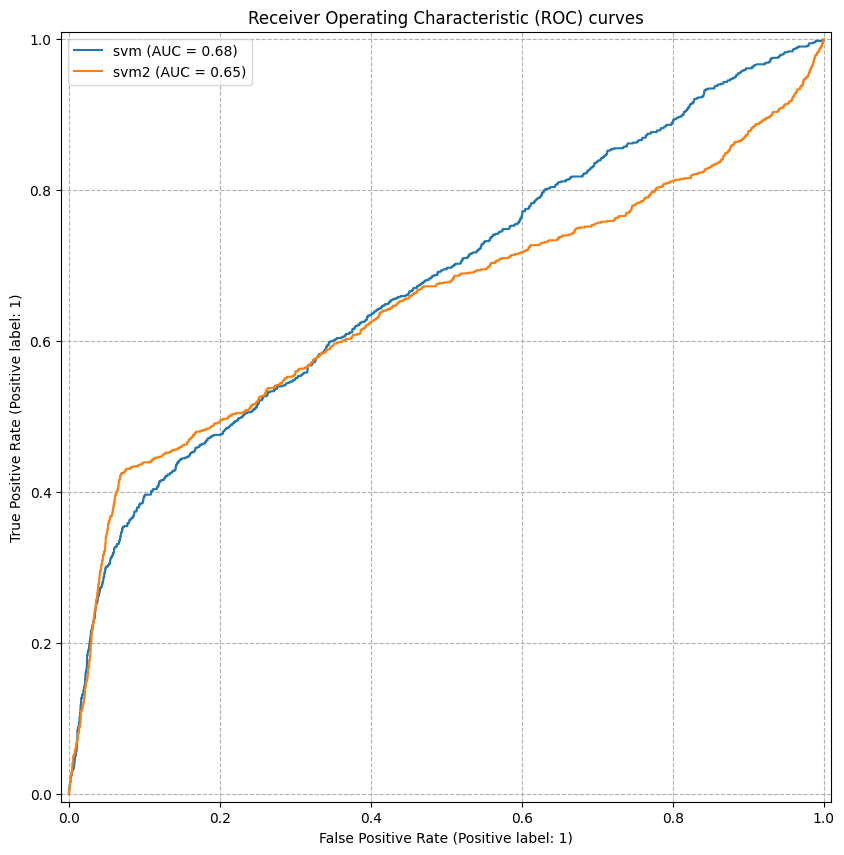

In [168]:
plot_roc_curves(models_and_params, grid_search_results, X_test, y_test)

A linha de código abaixo executa a função `plot_training_time`, que gera um gráfico para visualizar o **tempo de treino** dos diferentes modelos utilizados no processo de machine learning, que  é fundamental para comparar a eficiência computacional dos modelos e ajudar na escolha do melhor compromisso entre desempenho e custo computacional.


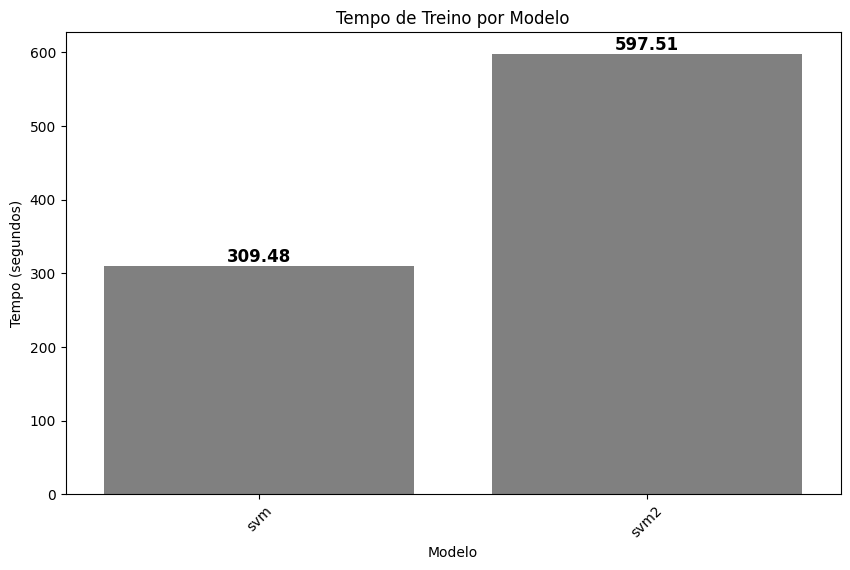

In [169]:
plot_training_time(resource_usage)

A linha de código abaixo executa a função `get_estimator_config`, que extrai a configuração otimizada do melhor modelo encontrado no processo de **Grid Search**. Este modelo será utilizado para cross validation com a outra classe de algoritmos.


In [170]:
svm_optimized = get_estimator_config(models_and_params, grid_search_results_overall["df_best_model"]["model_name"].iloc[0])
svm_optimized

('svm',
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('Classifier', SVC(random_state=42))]),
 {'Classifier__C': [0.1, 1, 10],
  'Classifier__gamma': array([1.00000000e-09, 2.15443469e-08, 4.64158883e-07, 1.00000000e-05,
         2.15443469e-04, 4.64158883e-03, 1.00000000e-01, 2.15443469e+00,
         4.64158883e+01, 1.00000000e+03]),
  'Classifier__kernel': ['linear']})

A análise das curvas ROC para os dois modelos SVM (svm e svm2) revelam diferenças  no desempenho preditivo, influenciadas pelas configurações de hiperparâmetros e pelos kernels utilizados.

O primeiro modelo, svm, que utiliza um kernel linear, apresentou um desempenho superior, com uma área sob a curva (AUC) de 0.68. Isto indica que consegue separar melhor as classes e, consequentemente, terá melhor capacidade preditivia. O comportamento da sua curva ROC mostra que, em termos de taxa de falsos positivos mais baixas, o modelo mantém um bom equilíbrio entre a taxa de verdadeiros positivos, sugerindo uma melhor capacidade de discriminação entre as classes.

Por outro lado, o modelo svm2, que utiliza o kernel RBF (Radial Basis Function), obteve um desempenho inferior, com um AUC de 0.65. Apesar da flexibilidade do kernel RBF, que geralmente permite captar relações mais complexas entre as variáveis, neste caso o modelo não conseguiu superar a performance do kernel linear. Isto pode indicar talvez que os valores definidos para os hiperparâmetros, como C e gamma, podem  não ter sido os mais adequados, resultando numa separação menos eficaz das classes.

### Find best hiperparameters in Decision Tree

Seguindo para o próximo algorimo `Decision Tree`. Numa primeiro momento  foi execytado o método RandomizedSearchCV para procurar os melhores hiperparâmetros 

In [171]:
# Definir o modelo
estimator = tree.DecisionTreeClassifier(random_state=seed)

# Definir espaço de hiperparâmetros
param_dist = {
    'max_depth': [2, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 4, 10, 20, 50],
    'criterion': ["gini", "entropy"],
    'splitter': ["best", "random"]
}

# Obter melhores parametros
best_otimized_model = get_optimal_param_RandomizedSearchCV(estimator, param_dist, X_train, y_train)

Melhores hiperparâmetros para DecisionTreeClassifier: {'splitter': 'best', 'min_samples_split': 50, 'min_samples_leaf': 4, 'max_depth': 5, 'criterion': 'gini'}


c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [172]:
# Aplicar a função para criar valores dicionario como array
best_otimized_model_params  = transform_dict_values(best_otimized_model.best_params_)

O código define um conjunto de modelos de `decision tree` juntamente com os seus hiperparâmetros para otimizaçãoo, variando parâmetros essenciais como profundidade da árvore (max_depth), critério de divisão (criterion), método de divisão (splitter), e restrições de amostragem (min_samples_split, min_samples_leaf). A estrutura do código permite comparar múltiplas variações do Decision Tree, desde configurações mais simples até configurações com maior regularização.A ultima configuração representa a versão onde os hiperparâmetros foram encontrados previamente utilizando RandomizedSearchCV, garantindo supostamente que os melhores valores são utilizados diretamente

In [173]:
models_and_params = [

    (
        'decision_tree',
        tree.DecisionTreeClassifier(random_state = seed),
        {
            'max_depth':[2, 4, 6,8],
            'min_samples_split': [2, 4, 6, 10],
            'criterion': ["gini",],
            'splitter': ["best","random"],
            'min_samples_leaf': [1,4,10]
        }
    ),

     (
        'decision_tree2',
        tree.DecisionTreeClassifier(random_state = seed),
        {
            'max_depth': [2, 5, 10, 20, None],  # Testar árvores mais profundas
            'min_samples_split': [2, 4, 6, 10],
            'criterion': ["gini",],
            'splitter': ["best","random"],
            'min_samples_leaf': [1,4,10]
        }
    ),

         (
        'decision_tree3',
        tree.DecisionTreeClassifier(random_state = seed),
        {
            'max_depth': [2, 5, 10, 20, None],  # Testar árvores mais profundas
            'min_samples_split': [2, 5, 10, 20, 50],  # Evita overfitting
            'criterion': ["gini",],
            'splitter': ["best","random"],
            'min_samples_leaf': [1,4,10]
        }
    ),


             (
        'decision_tree4',
        tree.DecisionTreeClassifier(random_state = seed),
        {
            'max_depth': [2, 5, 10, 20, None],  # Testar árvores mais profundas
            'min_samples_split': [2, 5, 10, 20, 50],  # Evita overfitting
            'criterion': ["gini",],
            'splitter': ["best","random"],
            'min_samples_leaf': [1, 4, 10, 20, 50],  # Regularização extra
        }
    ),

        (
        'decision_tree5',
        tree.DecisionTreeClassifier(random_state = seed),
        {
            'max_depth':[2, 4, 6,8],
            'min_samples_split': [2, 4, 6, 10],
            'criterion': ["gini", "entropy"],  # Testar diferentes critérios
            'splitter': ["best","random"],
            'min_samples_leaf': [1,4,10]
        }
    ),

        (
        'decision_tree_Random_SearchCV',
        tree.DecisionTreeClassifier(random_state = seed),
        best_otimized_model_params
    )
]

Código abaixo executa a função `train_models_with_gridsearch2`, que treina vários modelos definidos anteriormente utilizando a técnica de **Grid Search** para otimização dos hiperparâmetros. 


In [174]:
grid_search_results, resource_usage, grid_search_results_overall = train_models_with_gridsearch2(models_and_params, X_train, y_train, X_test, y_test)

Treinando modelo: decision_tree...
Modelo decision_tree concluído em 6.96 segundos. ROC AUC: 0.7695

Treinando modelo: decision_tree2...
Modelo decision_tree2 concluído em 11.44 segundos. ROC AUC: 0.7684

Treinando modelo: decision_tree3...


c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Modelo decision_tree3 concluído em 13.94 segundos. ROC AUC: 0.7683

Treinando modelo: decision_tree4...
Modelo decision_tree4 concluído em 22.05 segundos. ROC AUC: 0.7683

Treinando modelo: decision_tree5...
Modelo decision_tree5 concluído em 12.07 segundos. ROC AUC: 0.7643

Treinando modelo: decision_tree_Random_SearchCV...
Modelo decision_tree_Random_SearchCV concluído em 0.11 segundos. ROC AUC: 0.7683



c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


 Abaixo é executado a função `plot_roc_curves`, que gera gráfico das **Curvas ROC (Receiver Operating Characteristic)** para os modelos treinados. Através da representação desta métrica conseguimos  avaliar o desempenho dos modelos de classificação binária, permitindo visualizar a relação entre a **taxa de verdadeiros positivos (sensibilidade)** e a **taxa de falsos positivos**.


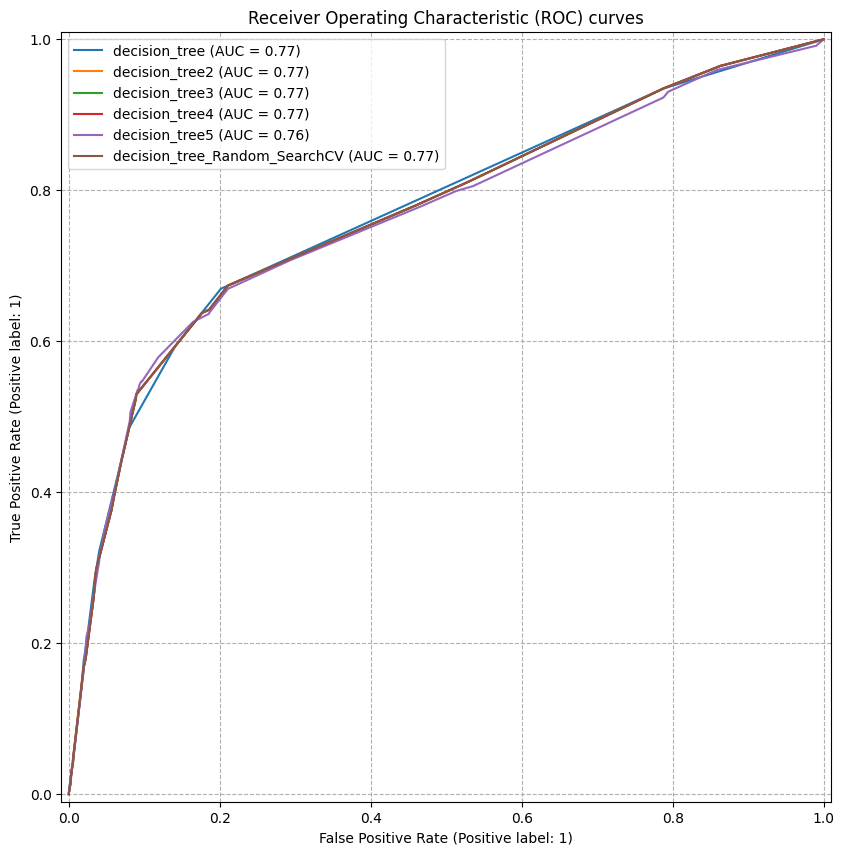

In [175]:
plot_roc_curves(models_and_params, grid_search_results, X_test, y_test)

A linha de código abaixo executa a função `plot_training_time`, que gera um gráfico para visualizar o **tempo de treino** dos diferentes modelos utilizados no processo de machine learning, que  é fundamental para comparar a eficiência computacional dos modelos e ajudar na escolha do melhor compromisso entre desempenho e custo computacional.

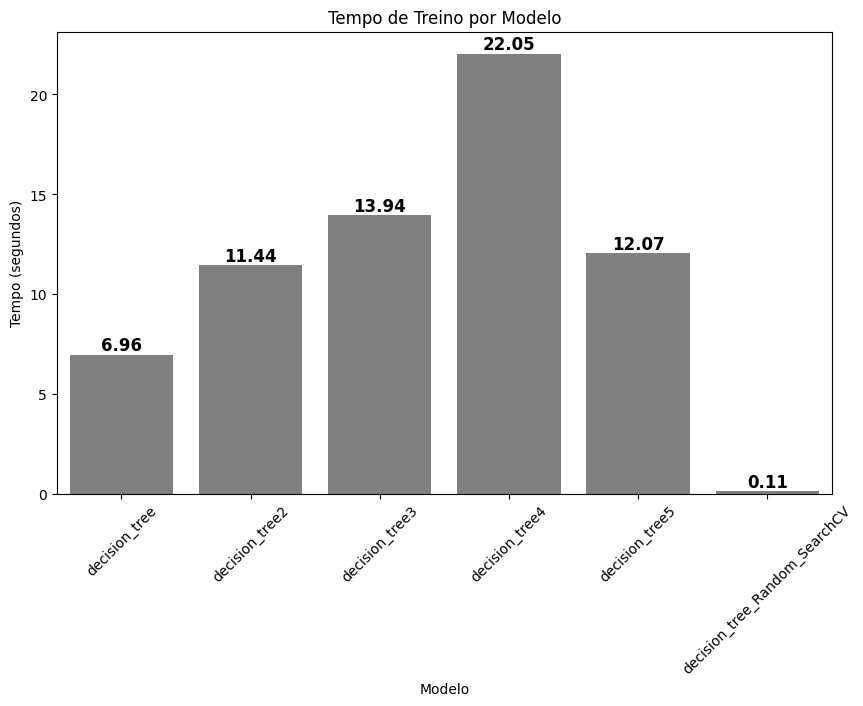

In [176]:
plot_training_time(resource_usage)

A linha de código abaixo executa a função `get_estimator_config`, que extrai a configuração otimizada do melhor modelo encontrado no processo de **Grid Search**. Este modelo será utilizado para cross validation com a outra classe de algoritmos.

In [177]:
decision_tree_optimized = get_estimator_config(models_and_params, grid_search_results_overall["df_best_model"]["model_name"].iloc[0])
decision_tree_optimized

('decision_tree',
 DecisionTreeClassifier(random_state=42),
 {'max_depth': [2, 4, 6, 8],
  'min_samples_split': [2, 4, 6, 10],
  'criterion': ['gini'],
  'splitter': ['best', 'random'],
  'min_samples_leaf': [1, 4, 10]})

A análise dos resultados obtidos para os diferentes modelos de Árvores de Decisão revela um comportamento bastante consistente em termos de desempenho, com pequenas variações na métrica ROC AUC mas diferenças maiores no tempo de treino. O modelo inicial decision_tree obteve o melhor desempenho, com um ROC AUC de 0.7695, e um tempo de treino relativamente curto de 5.88 segundos. Esta configuração, que utilizou profundidades mais limitadas e restrições moderadas nos critérios de divisão, mostrou-se eficiente tanto em termos de generalização como de tempo computacional.

Por outro lado, o modelo decision_tree2, que testou árvores mais profundas, não trouxe melhorias significativas, atingindo um AUC ligeiramente inferior (0.7684), enquanto o tempo de treino quase duplicou para 10.82 segundos. De forma semelhante, decision_tree3 e decision_tree4 tentaram reduzir o overfitting ao introduzir restrições adicionais, como valores mais elevados para min_samples_split e min_samples_leaf, mas sem impacto em termos de performance, mantendo um AUC em torno de 0.7683, mas aumentando custo de tempos de treino.

O modelo decision_tree5, que adicionou diferentes critérios de impureza (gini e entropy), apresentou um AUC ligeiramente inferior (0.7643), o que sugere que a escolha do critério de impureza não teve um impacto positivo na performance. 

Deste modo, os resultados indicam que aumentar a complexidade dos modelos nem sempre resulta numa melhoria de desempenho significativa e pode, muitas vezes, apenas aumentar o custo computacional sem benefícios reais. O modelo inicial (decision_tree) apresentou a melhor combinação de performance e eficiência, enquanto a utilização de RandomizedSearchCV provou ser uma abordagem eficaz para otimizar hiperparâmetros de forma rápida e eficiente, no entanto  não trouxe ganhos adicionais, uma vez que a configuração otimizada obteve exatamente o mesmo valor de AUC das versões ajustadas manualmente

### Find best hiperparameters in  Random Forest

O código apresentado tem como objetivo encontrar a melhor configuração de hiperparâmetros para um modelo Random Forest, utilizando RandomizedSearchCV para otimizar o desempenho preditivo enquanto reduz a carga computacional.

In [178]:
# Criar modelo base
estimator = RandomForestClassifier(random_state=seed)

# Definir espaço de hiperparâmetros
param_dist = {
    'n_estimators': [50, 100, 300, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10, 20],
    'max_features': ["sqrt", "log2", None]
}

# Obter melhores parametros
best_otimized_model = get_optimal_param_RandomizedSearchCV(estimator, param_dist, X_train, y_train)

c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Melhores hiperparâmetros para RandomForestClassifier: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 5}


In [179]:
# Aplicar a função
best_otimized_model_params  = transform_dict_values(best_otimized_model.best_params_)

A estratégia adotada para a otimização dos hiperparâmetros do modelo Random Forest baseou-se na seleção de diferentes configurações, permitindo avaliar o impacto de várias combinações de hiperparâmetros no desempenho do modelo. Para isso, foram criadas duas configurações distintas de Random Forest, cada uma explorando diferentes níveis de complexidade e regularização, além de uma terceira versão otimizada por RandomizedSearchCV.

A primeira configuração, random_forest, utiliza um espaço de busca mais restrito, onde o número de árvores (n_estimators) varia entre 10, 100, 300 e 500, enquanto a profundidade máxima das árvores (max_depth) está limitada a 2, 4 ou 6 níveis. Esta abordagem visa restringir a complexidade do modelo, garantindo um equilíbrio entre capacidade preditiva e risco de overfitting.

A segunda configuração, random_forest2, relativamente ao  número de árvores testadas mantém-se entre 50, 100, 300 e 500, mas a profundidade máxima (max_depth) inclui valores mais elevados, variando entre 5, 10, 20 e sem restrição (None). Esta configuração permite avaliar  se o aumento da profundidade das árvores resulta numa melhoria do desempenho preditivo.

A terceira e última configuração, random_forest_RandomSearchCV, representa o modelo final otimizado, onde os hiperparâmetros foram ajustados utilizando RandomizedSearchCV.

In [180]:
models_and_params = [

    (
        'random_forest',
        RandomForestClassifier(random_state = seed),
        {
            'n_estimators':[10, 100, 300,500],
            'max_depth':[2, 4, 6]
        }
    ),
        (
        'random_forest2',
        RandomForestClassifier(random_state = seed),
        {
            'n_estimators':[50, 100, 300, 500],
            'max_depth':[5, 10, 20, None]
        }
    ),
        #hiperparametros obtidos em RandomizedSearchCV
        (
        'random_forest_RandomSearchCV',
        RandomForestClassifier(random_state=seed),
        best_otimized_model_params
    )

]

Código abaixo executa a função `train_models_with_gridsearch2`, que treina vários modelos definidos anteriormente utilizando a técnica de **Grid Search** para otimização dos hiperparâmetros. 

In [181]:
grid_search_results, resource_usage, grid_search_results_overall = train_models_with_gridsearch2(models_and_params, X_train, y_train, X_test, y_test)

Treinando modelo: random_forest...


c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Modelo random_forest concluído em 64.53 segundos. ROC AUC: 0.7669

Treinando modelo: random_forest2...
Modelo random_forest2 concluído em 206.68 segundos. ROC AUC: 0.7770

Treinando modelo: random_forest_RandomSearchCV...
Modelo random_forest_RandomSearchCV concluído em 3.32 segundos. ROC AUC: 0.7711



 Abaixo é executado a função `plot_roc_curves`, que gera gráfico das **Curvas ROC (Receiver Operating Characteristic)** para os modelos treinados. Através da representação desta métrica conseguimos  avaliar o desempenho dos modelos de classificação binária, permitindo visualizar a relação entre a **taxa de verdadeiros positivos (sensibilidade)** e a **taxa de falsos positivos**.

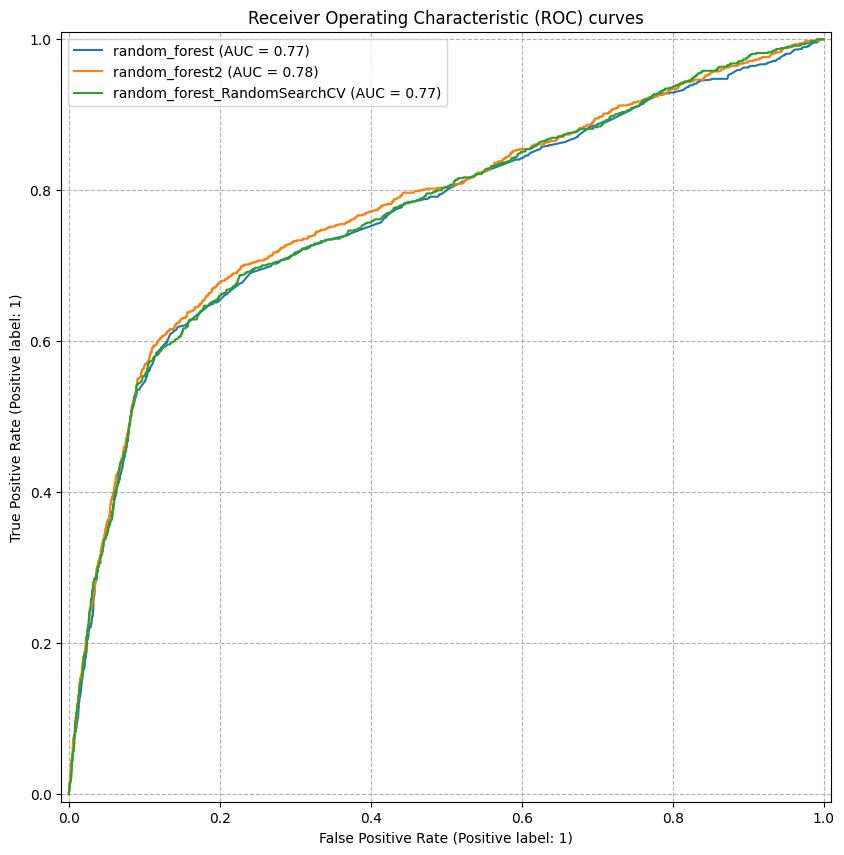

In [182]:
plot_roc_curves(models_and_params, grid_search_results, X_test, y_test)

Analisando curvas ROC para os diferentes modelos de Random Forest, o primeiro modelo, random_forest, utilizou uma configuração base com um espaço de busca mais restrito para os hiperparâmetros, o que resultou num AUC de 0.7669 e um tempo de treino de 62.02 segundos. Este modelo mostrou um desempenho consistente, conseguindo um bom equilíbrio entre a taxa de verdadeiros positivos e a taxa de falsos positivos.

O segundo modelo, random_forest2, explorou configurações de árvores mais profundas. Como resultado, houve uma ligeira melhoria no desempenho preditivo (AUC de 0.7770), porém, com um custo computacional elevado, levando 250.59 segundos para treinar. Esta diferença sugere que, embora o aumento da complexidade possa trazer ganhos marginais, o impacto no tempo de treino é significativo, tornando a abordagem menos eficiente em termos de desempenho computacional.

O último modelo, random_forest_RandomSearchCV, utilizou RandomizedSearchCV para otimizar os hiperparâmetros, que conseguiu um AUC de 0.7711, muito próximo ao do modelo mais complexo. Esta combinação de hiperparametros sugere um bom equilibrio em termos de performance e eficiência.

A linha de código abaixo executa a função `plot_training_time`, que gera um gráfico para visualizar o **tempo de treino** dos diferentes modelos utilizados no processo de machine learning, que  é fundamental para comparar a eficiência computacional dos modelos e ajudar na escolha do melhor compromisso entre desempenho e custo computacional.

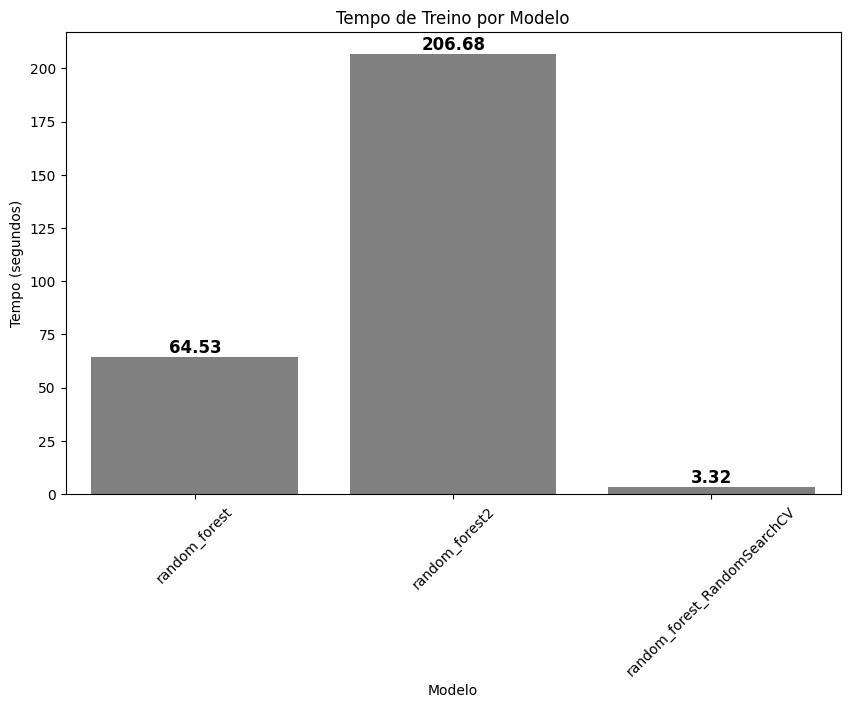

In [183]:
plot_training_time(resource_usage)

A linha de código abaixo executa a função `get_estimator_config`, que extrai a configuração otimizada do melhor modelo encontrado no processo de **Grid Search**. Este modelo será utilizado para cross validation com a outra classe de algoritmos.

In [184]:
random_forest_optimized = get_estimator_config(models_and_params, grid_search_results_overall["df_best_model"]["model_name"].iloc[0])
random_forest_optimized

('random_forest2',
 RandomForestClassifier(random_state=42),
 {'n_estimators': [50, 100, 300, 500], 'max_depth': [5, 10, 20, None]})

### Find best hiperparameters in KNN

O código apresentado tem como objetivo otimizar os hiperparâmetros do modelo K-Nearest Neighbors (KNN), utilizando RandomizedSearchCV para encontrar a melhor configuração de parâmetros de forma eficiente.

In [185]:
# Criar modelo base
estimator = KNeighborsClassifier()

# Definir espaço de hiperparâmetros
param_dist = {
    "n_neighbors": [3, 5, 10, 20, 50],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

# Obter melhores parametros
best_otimized_model = get_optimal_param_RandomizedSearchCV(estimator, param_dist, X_train, y_train)

Melhores hiperparâmetros para KNeighborsClassifier: {'weights': 'uniform', 'n_neighbors': 50, 'metric': 'euclidean'}


c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [186]:
# Aplicar a função transformar os valores em listas
best_otimized_model_params  = transform_dict_values(best_otimized_model.best_params_)
best_otimized_model_params

{'weights': ['uniform'], 'n_neighbors': [50], 'metric': ['euclidean']}

In [187]:
# Aplicar a função para adicionar prefixo "Classifier__"
best_otimized_model_params = add_prefix_to_keys(best_otimized_model_params, "Classifier__")
best_otimized_model_params

{'Classifier__weights': ['uniform'],
 'Classifier__n_neighbors': [50],
 'Classifier__metric': ['euclidean']}

A estratégia adotada para a otimização dos hiperparâmetros do modelo K-Nearest Neighbors (KNN) baseou-se na experimentação de diferentes configurações, permitindo avaliar o impacto de múltiplas combinações de parâmetros na performance do modelo. Para isso, foram criadas quatro variações do KNN, abrangendo desde configurações mais simples até um modelo otimizado com RandomizedSearchCV.

Na configuração inicial, representada pelo modelo knn, é apenas especificado o número de vizinhos (n_neighbors), utilizando os valores 1, 10 e 100, e utilizando os restantes valores default. 

Na segunda configuração, knn2, além da variação do número de vizinhos, é introduzida a variável weights, sendo testada a opção "distance", onde vizinhos mais próximos têm maior influência na decisão. Esta modificação permite verificar se ponderar os vizinhos de acordo com a proximidade melhora a capacidade preditiva do modelo.

Na terceira configuração, knn3, adiciona-se um conjunto mais alargado de hiperparâmetros. Além de testar diferentes valores de n_neighbors, são incluídas as opções "uniform" e "distance" para weights, bem como diferentes métricas de distância (metric), nomeadamente "euclidean", "manhattan"  e "minkowski" (uma generalização das anteriores). Este modelo visa testar qual métrica de proximidade melhor se adapta aos dados e se o peso dos vizinhos influencia positivamente a performance do modelo.

Por fim, a versão knn_RandomSearchCV representa o modelo final otimizado, onde os melhores hiperparâmetros são encontrados utilizando RandomizedSearchCV. Esta abordagem permite reduzir o tempo de busca de hiperparâmetros ao testar apenas um subconjunto de combinações, garantindo uma solução eficiente em termos computacionais, sem comprometer a capacidade preditiva.

In [188]:
models_and_params = [

    (
        'knn',
        Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('Classifier', KNeighborsClassifier())
        ]),
        {
          "Classifier__n_neighbors": [1,10,100]
        }
    ),

        (
        'knn2',
        Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('Classifier', KNeighborsClassifier())
        ]),
        {
          "Classifier__n_neighbors":[3, 5, 10, 20, 50],
           "Classifier__weights": ["distance"]
        }
    ),

        (
        'knn3',
        Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('Classifier', KNeighborsClassifier())
        ]),
        {
          "Classifier__n_neighbors":[3, 5, 10, 20, 50],
           "Classifier__weights": ["uniform", "distance"],
          "Classifier__metric": ["euclidean", "manhattan", "minkowski"]
        }
    ),

        (
        'knn_RandomSearchCV',
        Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('Classifier', KNeighborsClassifier())
        ]),
        best_otimized_model_params
    )
]

Código abaixo executa a função `train_models_with_gridsearch2`, que treina vários modelos definidos anteriormente utilizando a técnica de **Grid Search** para otimização dos hiperparâmetros. 

In [189]:
grid_search_results, resource_usage, grid_search_results_overall = train_models_with_gridsearch2(models_and_params, X_train, y_train, X_test, y_test)

Treinando modelo: knn...


c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Modelo knn concluído em 3.68 segundos. ROC AUC: 0.7567

Treinando modelo: knn2...
Modelo knn2 concluído em 2.07 segundos. ROC AUC: 0.6914

Treinando modelo: knn3...
Modelo knn3 concluído em 20.57 segundos. ROC AUC: 0.7466

Treinando modelo: knn_RandomSearchCV...
Modelo knn_RandomSearchCV concluído em 1.22 segundos. ROC AUC: 0.7492



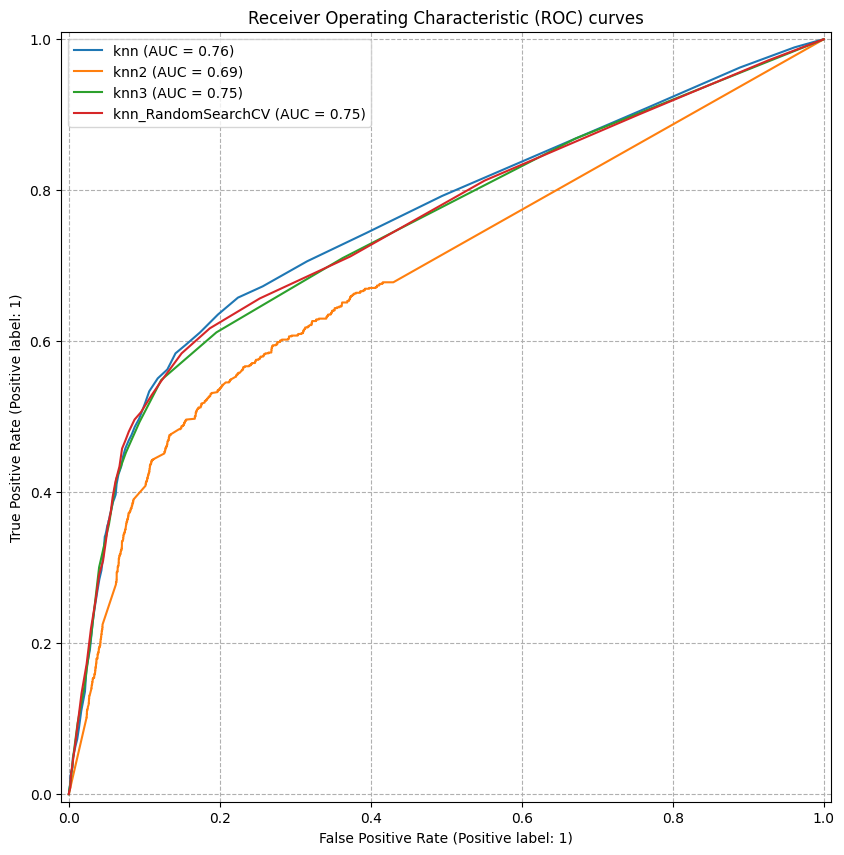

In [190]:
plot_roc_curves(models_and_params, grid_search_results, X_test, y_test)

A análise dos resultados obtidos para os diferentes modelos K-Nearest Neighbors (KNN) revelou variações significativas tanto no tempo de treino como no desempenho preditivo, à medida que diferentes configurações de hiperparâmetros foram testadas. O modelo knn, que apenas variou o número de vizinhos, apresentou o melhor desempenho global, com um ROC AUC de 0.7567 e um tempo de treino relativamente curto, de 4 segundos. 

Por outro lado, o modelo knn2, que introduziu a ponderação dos vizinhos através do parâmetro weights="distance", apresentou o pior desempenho, com um ROC AUC de apenas 0.6914, embora tenha sido o modelo mais rápido a treinar, demorando apenas 2.04 segundos. Isto indica que, para este conjunto de dados específico, atribuir maior peso aos vizinhos mais próximos não trouxe melhorias e pode ter tornado o modelo mais sensível ao ruído nos dados.

A terceira configuração, representada pelo modelo knn3, incluiu diferentes métricas de distância, nomeadamente "euclidean", "manhattan" e "minkowski", além da variação do número de vizinhos e da ponderação dos pesos. Contudo, esta abordagem resultou num tempo de treino bastante superior, 18.68 segundos, sem trazer melhorias significativas no desempenho, uma vez que obteve um AUC de 0.7466, inferior ao modelo knn. Isto sugere que, apesar de testar diferentes métricas de distância, a escolha da métrica não teve um impacto significativo no desempenho preditivo.

Por fim, o modelo knn_RandomSearchCV, que utilizou RandomizedSearchCV para encontrar automaticamente a melhor configuração de hiperparâmetros, alcançou um AUC de 0.7492. Este resultado destaca a eficácia do RandomizedSearchCV, que conseguiu um desempenho próximo ao modelo knn3, mas com um custo computacional muito inferior. Isto indica que a busca aleatória conseguiu encontrar uma boa configuração de hiperparâmetros sem necessidade de testar todas as combinações possíveis.

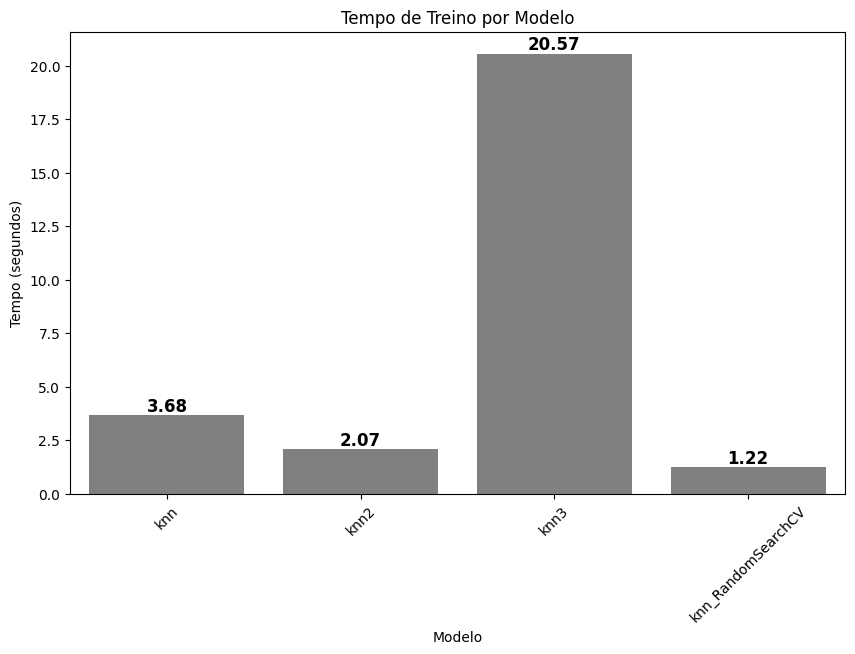

In [191]:
plot_training_time(resource_usage)

A linha de código abaixo executa a função `get_estimator_config`, que extrai a configuração otimizada do melhor modelo encontrado no processo de **Grid Search**. Este modelo será utilizado para cross validation com a outra classe de algoritmos.

In [192]:
knn_optimized = get_estimator_config(models_and_params, grid_search_results_overall["df_best_model"]["model_name"].iloc[0])
knn_optimized

('knn',
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('Classifier', KNeighborsClassifier())]),
 {'Classifier__n_neighbors': [1, 10, 100]})

### Find best hiperparameters in Regressão Logistica

O código apresentado tem como objetivo otimizar os hiperparâmetros da Regressão Logística, utilizando RandomizedSearchCV para encontrar a melhor configuração de forma eficiente

In [193]:
#Criar modelo base
estimator = LogisticRegression(random_state=seed, max_iter=500)

param_dist = [
    {"C": [0.01, 0.1, 1, 10, 100], "penalty": ["l1"], "solver": ["liblinear"]},
    {"C": [0.01, 0.1, 1, 10, 100], "penalty": ["l2"], "solver": ["lbfgs", "liblinear", "saga"]},
    {"C": [0.01, 0.1, 1, 10, 100], "penalty": ["elasticnet"], "solver": ["saga"], "l1_ratio": [0.1, 0.5, 0.9]},
    {"C": [0.01, 0.1, 1, 10, 100], "penalty": [None], "solver": ["lbfgs", "saga"]}
]

# Obter melhores parâmetros para a Regressão Logística
best_otimized_model = get_optimal_param_RandomizedSearchCV(estimator,param_dist, X_train, y_train)

Melhores hiperparâmetros para LogisticRegression: {'solver': 'lbfgs', 'penalty': None, 'C': 1}


In [194]:
# Aplicar a função pa transformar valores em listas
best_otimized_model_params  = transform_dict_values(best_otimized_model.best_params_)
best_otimized_model_params

{'solver': ['lbfgs'], 'penalty': [None], 'C': [1]}

In [195]:
# Aplicar a função para adicionar prefixo "Classifier__"
best_otimized_model_params = add_prefix_to_keys(best_otimized_model_params, "Classifier__")
best_otimized_model_params

{'Classifier__solver': ['lbfgs'],
 'Classifier__penalty': [None],
 'Classifier__C': [1]}

O código abaixo define o conjunto de configurações utilizados no algoritmo Regressão Logistica juntamente com os seus hiperparâmetros para otimização. Foram criadas duas versões do modelo, desde uma configuração manual até um modelo otimizado com RandomizedSearchCV.

Na primeira versão, logit, testa-se uma configuração inicial de hiperparâmetros, onde o parâmetro C varia entre 0.1, 1, 10 e 100, permitindo avaliar a influência da regularização no modelo. Um valor pequeno de C implica uma regularização mais forte, evitando overfitting, enquanto valores maiores permitem ao modelo ajustar-se melhor aos dados. Além disso, utiliza-se penalização L2 (ridge regression), que reduz a magnitude dos coeficientes, evitando que o modelo seja excessivamente sensível a pequenas variações nos dados.

Na segunda versão, logit_RandomSearchCV, o modelo é otimizado com os melhores hiperparâmetros encontrados através do RandomizedSearchCV, armazenados em best_otimized_model_params. O RandomizedSearchCV permite testar uma amostra aleatória das combinações possíveis de hiperparâmetros, garantindo uma busca mais eficiente sem necessidade de testar todas as opções como no GridSearchCV.

In [196]:
models_and_params = [

    (
        'logit',
        Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('Classifier', LogisticRegression(random_state = seed))
        ]),
        {
          "Classifier__C": [0.1, 1, 10, 100],
          "Classifier__penalty": ['l2'],
        }
    ),

      (
        'logit_RandomSearchCV',
        Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('Classifier', LogisticRegression(random_state = seed))
        ]),
        best_otimized_model_params
    )
]

Código abaixo executa a função `train_models_with_gridsearch2`, que treina vários modelos definidos anteriormente utilizando a técnica de **Grid Search** para otimização dos hiperparâmetros. 

In [197]:
grid_search_results, resource_usage, grid_search_results_overall = train_models_with_gridsearch2(models_and_params, X_train, y_train, X_test, y_test)

Treinando modelo: logit...
Modelo logit concluído em 0.84 segundos. ROC AUC: 0.7492

Treinando modelo: logit_RandomSearchCV...
Modelo logit_RandomSearchCV concluído em 0.23 segundos. ROC AUC: 0.7492



 Abaixo é executado a função `plot_roc_curves`, que gera gráfico das **Curvas ROC (Receiver Operating Characteristic)** para os modelos treinados. Através da representação desta métrica conseguimos  avaliar o desempenho dos modelos de classificação binária, permitindo visualizar a relação entre a **taxa de verdadeiros positivos (sensibilidade)** e a **taxa de falsos positivos**.

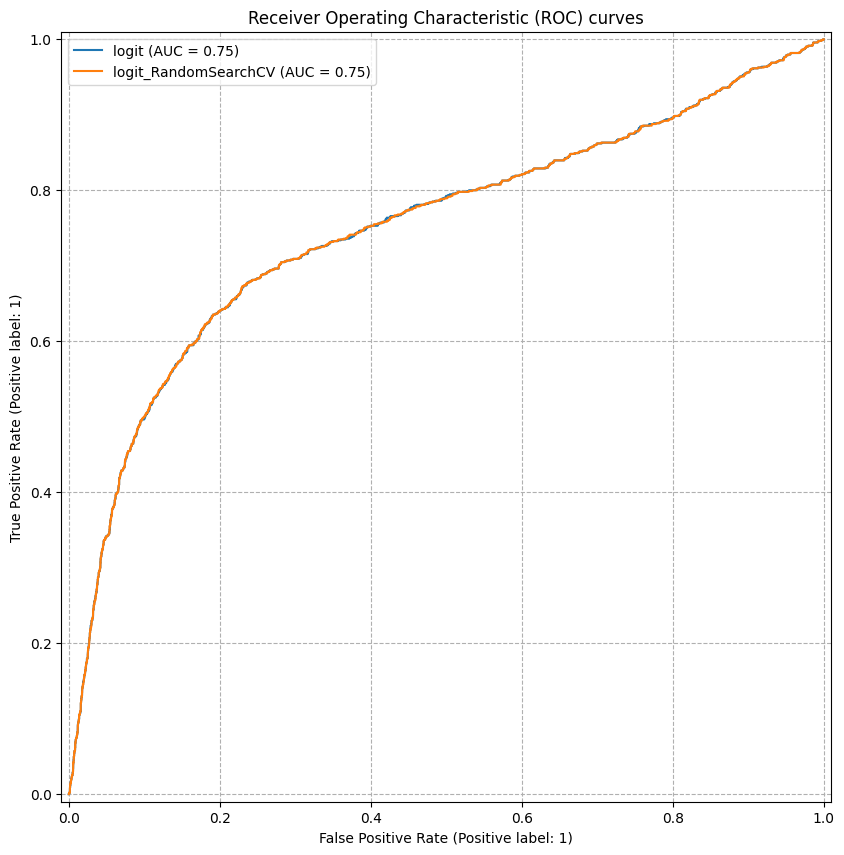

In [198]:
plot_roc_curves(models_and_params, grid_search_results, X_test, y_test)

A análise das curvas ROC para a Regressão Logística nas suas duas configurações, logit (versão manual) e logit_RandomSearchCV (versão otimizada por RandomizedSearchCV), revela que ambas apresentam exatamente o mesmo desempenho, com um AUC fixo em 0.75. Isso indica que a otimização dos hiperparâmetros não trouxe melhorias na capacidade discriminativa do modelo.

Além disso, observa-se que as curvas estão praticamente sobrepostas, sugerindo que os hiperparâmetros otimizados por RandomizedSearchCV não foram capazes de superar a configuração manualmente definida. Esse comportamento pode indicar que o modelo atingiu um limite de performance com os dados disponíveis, e que ajustes nos hiperparâmetros não são suficientes para aumentar a capacidade de distinção entre classes

A linha de código abaixo executa a função `plot_training_time`, que gera um gráfico para visualizar o **tempo de treino** dos diferentes modelos utilizados no processo de machine learning, que  é fundamental para comparar a eficiência computacional dos modelos e ajudar na escolha do melhor compromisso entre desempenho e custo computacional.

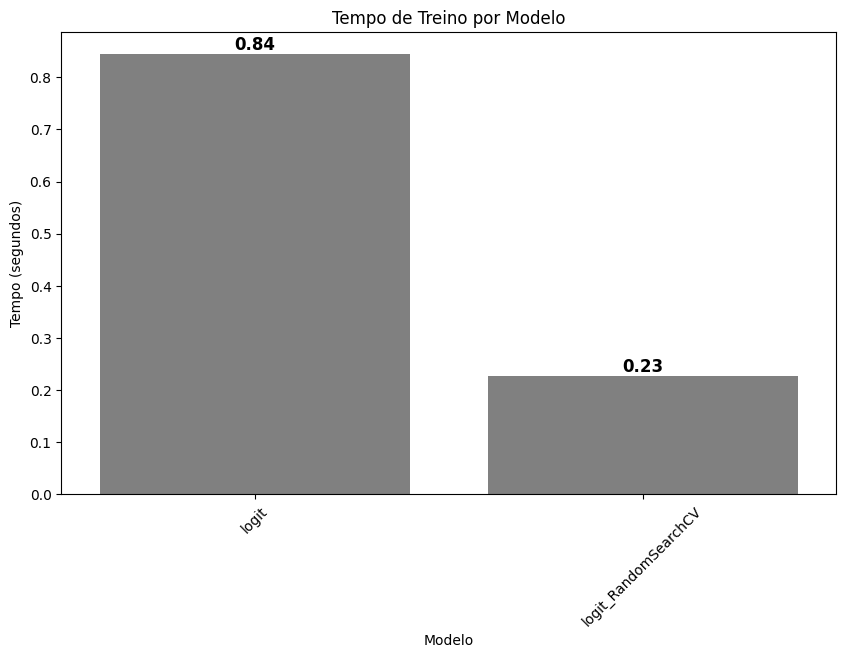

In [199]:
plot_training_time(resource_usage)

A linha de código abaixo executa a função `get_estimator_config`, que extrai a configuração otimizada do melhor modelo encontrado no processo de **Grid Search**. Este modelo será utilizado para cross validation com a outra classe de algoritmos.

In [200]:
logit_optimized = get_estimator_config(models_and_params, grid_search_results_overall["df_best_model"]["model_name"].iloc[0])
logit_optimized

('logit_RandomSearchCV',
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('Classifier', LogisticRegression(random_state=42))]),
 {'Classifier__solver': ['lbfgs'],
  'Classifier__penalty': [None],
  'Classifier__C': [1]})

### Rede Neural Artificial

O código apresentado tem como objetivo otimizar os hiperparâmetros de uma Rede Neural Artificial (ANN) utilizando RandomizedSearchCV, permitindo encontrar a melhor configuração para um MLPClassifier (Perceptron Multicamadas).

In [201]:
# Criar modelo base
estimator = MLPClassifier(random_state=seed, max_iter=1000)

# Definir espaço de hiperparâmetros para ANN
param_dist = {
    "hidden_layer_sizes": [(20,), (40,), (20, 40), (40, 20), (20, 40, 60)],
    "activation": ["relu", "tanh", "logistic"],  # Função de ativação
    "solver": ["adam", "lbfgs", "sgd"],  # Algoritmos de otimização
    "alpha": [0.0001, 0.001, 0.01, 0.1],  # Regularização L2
    "learning_rate": ["constant", "adaptive", "invscaling"],  # Estratégia de taxa de aprendizagem
}

# Obter melhores parâmetros para ANN
best_optimized_model = get_optimal_param_RandomizedSearchCV(estimator,param_dist, X_train, y_train)

Melhores hiperparâmetros para MLPClassifier: {'solver': 'lbfgs', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (40,), 'alpha': 0.001, 'activation': 'logistic'}


In [202]:
# Aplicar a função para guardar valores em listas
best_otimized_model_params  = transform_dict_values(best_optimized_model.best_params_)
best_otimized_model_params

{'solver': ['lbfgs'],
 'learning_rate': ['adaptive'],
 'hidden_layer_sizes': [(40,)],
 'alpha': [0.001],
 'activation': ['logistic']}

In [203]:
# Aplicar a função para adicionar prefixo "Classifier__"
best_otimized_model_params = add_prefix_to_keys(best_otimized_model_params, "Classifier__")
best_otimized_model_params

{'Classifier__solver': ['lbfgs'],
 'Classifier__learning_rate': ['adaptive'],
 'Classifier__hidden_layer_sizes': [(40,)],
 'Classifier__alpha': [0.001],
 'Classifier__activation': ['logistic']}

A estratégia adotada para a otimização da Rede Neural Artificial (ANN) baseou-se  na experimentação de diferentes configurações do MLPClassifier, variando as arquiteturas da rede, o número de iterações e os algoritmos de otimização. Foram definidas três versões do modelo, permitindo comparar o impacto de diferentes hiperparâmetros no desempenho preditivo da rede.

Na primeira configuração, ann, testa-se uma variação nos tamanhos das camadas ocultas (hidden_layer_sizes), explorando desde arquiteturas simples, com apenas 20 ou 40 neurónios, até configurações mais profundas, como (20,40), (40,20) e (20,40,60). Além disso, são avaliadas duas opções para o número de iterações (max_iter), 100 e 1000, permitindo verificar o impacto do tempo de treino na convergência do modelo.

Na segunda versão, ann2, além das variações na arquitetura da rede e do número de iterações, introduz-se a restrição do solver para 'sgd' (gradiente descendente estocástico). O SGD pode ser menos estável do que Adam ou LBFGS, mas é útil para problemas de grande escala, onde os dados são atualizados de forma incremental, permitindo testar a sua eficácia no cenário analisado.

Por fim, a terceira configuração, ann_RandomSearchCV, representa a versão otimizada com os melhores hiperparâmetros encontrados via RandomizedSearchCV, armazenados em best_optimized_model_params. Esta abordagem permite testar automaticamente um conjunto mais amplo de combinações de hiperparâmetros, garantindo um ajuste mais eficiente sem necessidade de testar todas as possibilidades manualmente.

In [204]:
models_and_params = [
    (
        'ann',
        Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('Classifier', MLPClassifier(random_state=seed))
        ]),
        {
          "Classifier__hidden_layer_sizes": [(20),(40),(20,40),(40,20),(20,40,60),(60,40,20)],
          "Classifier__max_iter": [100,1000]
        }
    ),
    (
        'ann2',
        Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('Classifier', MLPClassifier(random_state=seed))
        ]),
        {
          "Classifier__hidden_layer_sizes": [(20),(40),(20,40),(40,20),(20,40,60),(60,40,20)],
          "Classifier__max_iter": [100,1000],
          "Classifier__solver": ['sgd']
        }
    ),
    (
        'ann_RandomSearchCV',
        Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('Classifier', MLPClassifier(random_state=seed))
        ]),
        best_otimized_model_params
    )
]

Código abaixo executa a função `train_models_with_gridsearch2`, que treina vários modelos definidos anteriormente utilizando a técnica de **Grid Search** para otimização dos hiperparâmetros. 

In [205]:
grid_search_results, resource_usage, grid_search_results_overall = train_models_with_gridsearch2(models_and_params, X_train, y_train, X_test, y_test)

Treinando modelo: ann...


c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: M

Modelo ann concluído em 225.94 segundos. ROC AUC: 0.7574

Treinando modelo: ann2...
Modelo ann2 concluído em 147.33 segundos. ROC AUC: 0.7498

Treinando modelo: ann_RandomSearchCV...


c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ne

Modelo ann_RandomSearchCV concluído em 94.14 segundos. ROC AUC: 0.7609



c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 Abaixo é executado a função `plot_roc_curves`, que gera gráfico das **Curvas ROC (Receiver Operating Characteristic)** para os modelos treinados. Através da representação desta métrica conseguimos  avaliar o desempenho dos modelos de classificação binária, permitindo visualizar a relação entre a **taxa de verdadeiros positivos (sensibilidade)** e a **taxa de falsos positivos**.

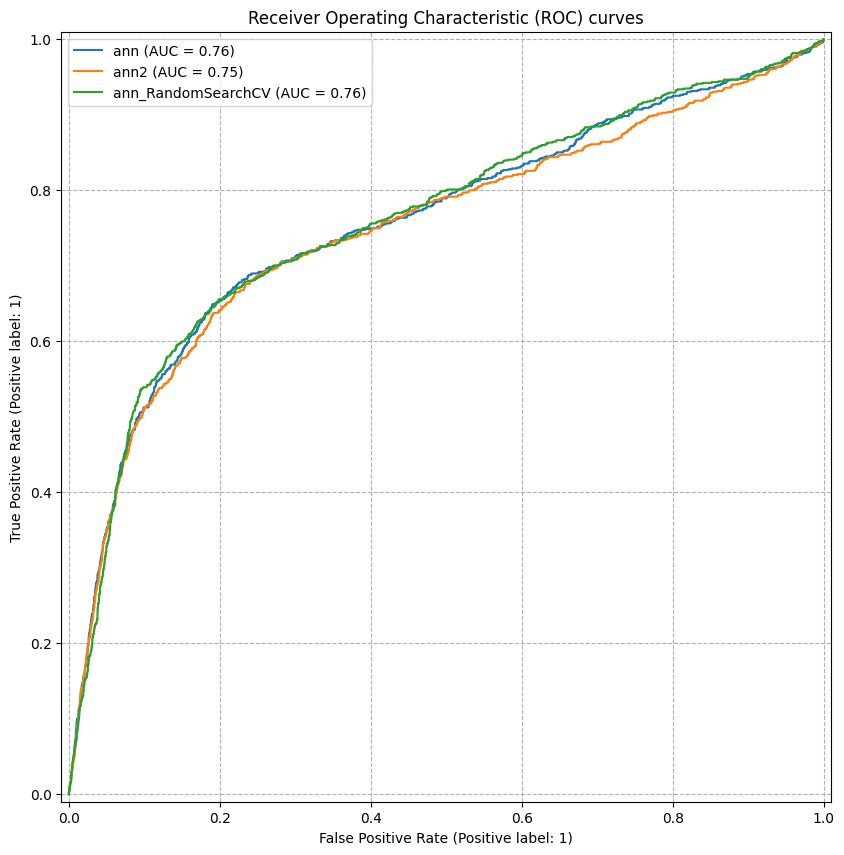

In [206]:
plot_roc_curves(models_and_params, grid_search_results, X_test, y_test)

A análise das curvas ROC para as diferentes configurações da Rede Neural Artificial (ANN) demonstrou variações no desempenho preditivo entre os modelos testados, refletindo o impacto dos ajustes nos hiperparâmetros. O modelo ann, que utiliza a configuração inicial com diferentes arquiteturas de camadas ocultas e número de iterações, apresentou o melhor desempenho, com um AUC de 0,76. Isto indica que esta configuração conseguiu um equilíbrio satisfatório entre capacidade de aprendizagem e generalização.

Por outro lado, a versão ann2, que utiliza o solver SGD (Stochastic Gradient Descent), apresentou o pior desempenho, com um AUC de 0,75. Este resultado pode indicar que o gradiente descendente estocástico não foi o método de otimização mais adequado para este problema, possivelmente devido à necessidade de um ajuste mais rigoroso da taxa de aprendizagem ou por ser mais sensível a variações nos dados.

Já a versão ann_RandomSearchCV, que utiliza os melhores hiperparâmetros encontrados via RandomizedSearchCV, obteve um AUC de 0,76. Apesar de apresentar um desempenho ligeiramente superior ao de ann2, não conseguiu superar o modelo inicial ann, sugerindo que a otimização automática dos hiperparâmetros não trouxe melhorias significativas na capacidade discriminativa da rede neuronal. Este comportamento pode ser explicado por limitações no espaço de busca dos hiperparâmetros testados ou pela necessidade de explorar configurações mais avançadas da rede.

Diante destes resultados, conclui-se que, apesar de a rede neuronal apresentar um desempenho competitivo, a otimização automática não resultou em ganhos expressivos, indicando que novos ajustes podem ser necessários para alcançar melhorias mais significativas.

A linha de código abaixo executa a função `plot_training_time`, que gera um gráfico para visualizar o **tempo de treino** dos diferentes modelos utilizados no processo de machine learning, que  é fundamental para comparar a eficiência computacional dos modelos e ajudar na escolha do melhor compromisso entre desempenho e custo computacional.

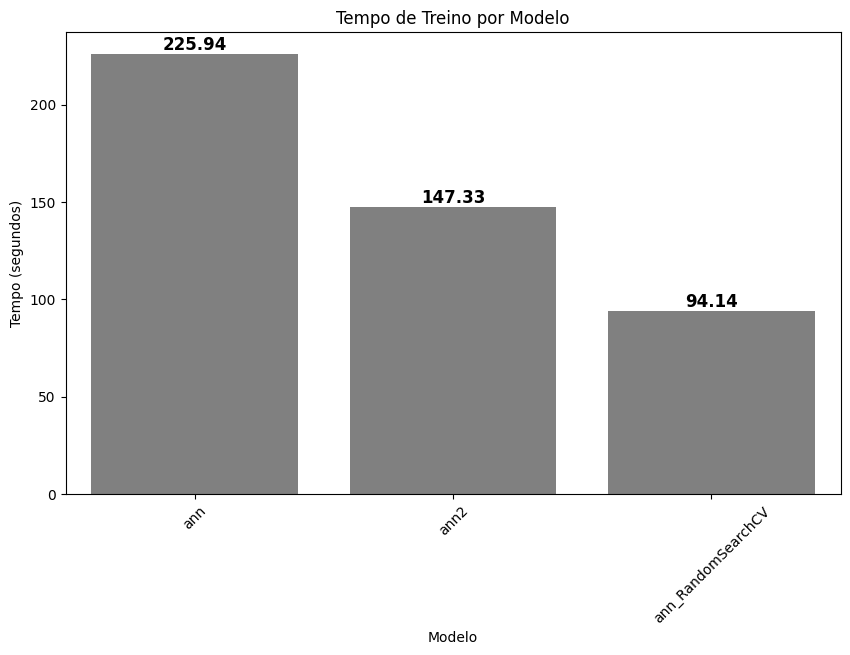

In [207]:
plot_training_time(resource_usage)

A linha de código abaixo executa a função `get_estimator_config`, que extrai a configuração otimizada do melhor modelo encontrado no processo de **Grid Search**. Este modelo será utilizado para cross validation com a outra classe de algoritmos.

In [208]:
ann_optimized = get_estimator_config(models_and_params, grid_search_results_overall["df_best_model"]["model_name"].iloc[0])
ann_optimized

('ann_RandomSearchCV',
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('Classifier', MLPClassifier(random_state=42))]),
 {'Classifier__solver': ['lbfgs'],
  'Classifier__learning_rate': ['adaptive'],
  'Classifier__hidden_layer_sizes': [(40,)],
  'Classifier__alpha': [0.001],
  'Classifier__activation': ['logistic']})

### Cross Validation entre diferentes Algoritmos

---

Após identificar a melhor configuração dentro de cada algoritmo, é implementado um pipeline com todas as classes de algoritmos preditivos sendo representado cada um a configuração que obteve melhor resultado dentro da análise do ponto anterior

In [209]:
models_and_params = [
   ann_optimized,
   random_forest_optimized,
   decision_tree_optimized,
   svm_optimized,
   knn_optimized,
   logit_optimized
]

Código abaixo executa a função `train_models_with_gridsearch2`, que treina vários modelos definidos anteriormente utilizando a técnica de **Grid Search** para otimização dos hiperparâmetros. 

In [210]:
grid_search_results, resource_usage, grid_search_results_overall = train_models_with_gridsearch2(models_and_params, X_train, y_train, X_test, y_test)

Treinando modelo: ann_RandomSearchCV...


c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ne

Modelo ann_RandomSearchCV concluído em 95.87 segundos. ROC AUC: 0.7609

Treinando modelo: random_forest2...
Modelo random_forest2 concluído em 207.89 segundos. ROC AUC: 0.7770

Treinando modelo: decision_tree...
Modelo decision_tree concluído em 6.49 segundos. ROC AUC: 0.7695

Treinando modelo: svm...
Modelo svm concluído em 324.84 segundos. ROC AUC: 0.6786

Treinando modelo: knn...


c:\Users\PereiraRodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Modelo knn concluído em 3.36 segundos. ROC AUC: 0.7567

Treinando modelo: logit_RandomSearchCV...
Modelo logit_RandomSearchCV concluído em 0.20 segundos. ROC AUC: 0.7492



O código  apresenta a curva ROC (Receiver Operating Characteristic) para os diferentes modelos treinados, permitindo comparar o desempenho de cada um no processo de classificação no conjunto de teste. O código percorre a lista de modelos armazenados em grid_search_results, extraindo o melhor estimador de cada modelo e gerando a respetiva curva ROC. O nome de cada modelo é incluído na legenda para facilitar a sua identificação.

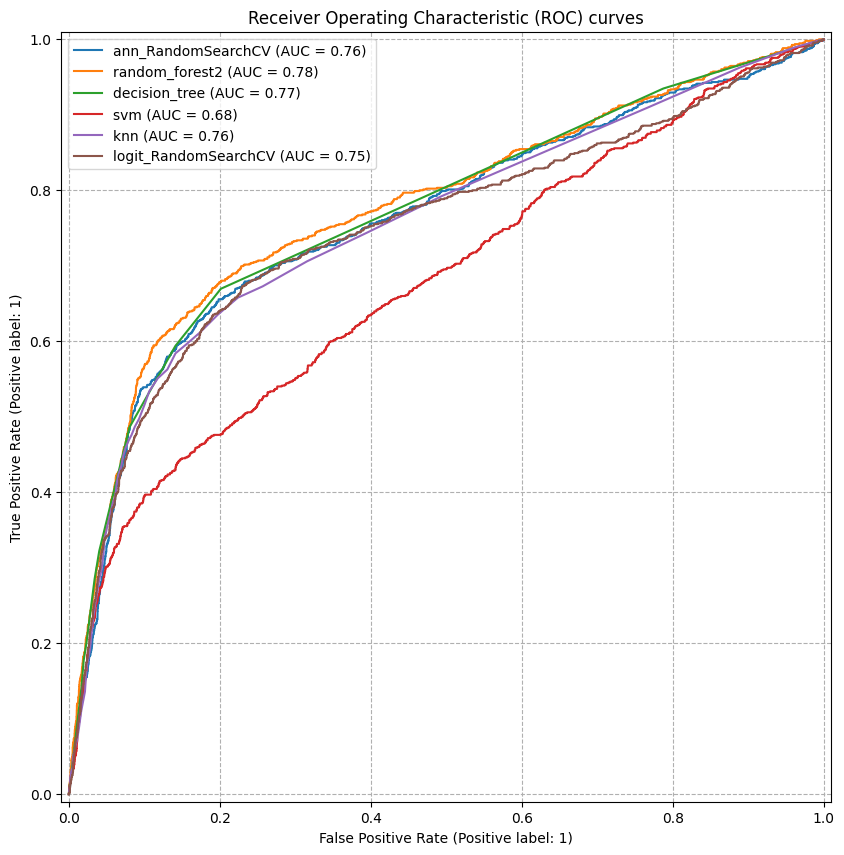

In [211]:
plot_roc_curves(models_and_params, grid_search_results, X_test, y_test)

No gráfico, observa-se que o modelo Random Forest (random_forest2) obteve a maior ROC AUC, com um valor de 0,7770, sugerindo que apresenta o melhor desempenho na distinção entre classes positivas e negativas.

O modelo Árvore de Decisão (decision_tree) registou um ROC AUC de 0,7695, ficando ligeiramente atrás do Random Forest, mas ainda demonstrando um bom desempenho preditivo. O modelo K-Nearest Neighbors (KNN) apresentou um ROC AUC de 0,7567, mostrando uma capacidade de classificação relativamente próxima dos anteriores.

A Regressão Logística otimizada (logit_RandomSearchCV) obteve um ROC AUC de 0,7492, o que indica um desempenho razoável, mas inferior ao de modelos baseados em árvores. Por outro lado, o Support Vector Machine (SVM) registou o menor desempenho, com um ROC AUC de 0,6786, sugerindo que pode não ser a melhor escolha para este problema específico.

Além das diferenças no desempenho, também se verifica uma variação significativa nos tempos de treino. O SVM foi o mais lento, demorando 465,37 segundos, enquanto o modelo mais rápido foi a Regressão Logística otimizada, concluída em 0,26 segundos. O Random Forest, apesar do melhor desempenho, teve um tempo de treino elevado (263,88 segundos), contrastando com a Árvore de Decisão, que apresentou um desempenho semelhante, mas com um tempo de treino significativamente menor (8,33 segundos).

As curvas ROC de todos os modelos seguem trajetórias relativamente semelhantes, à exceção do SVM, que apresentou um desempenho inferior, sugerindo que pode ser menos eficaz na previsão neste contexto.

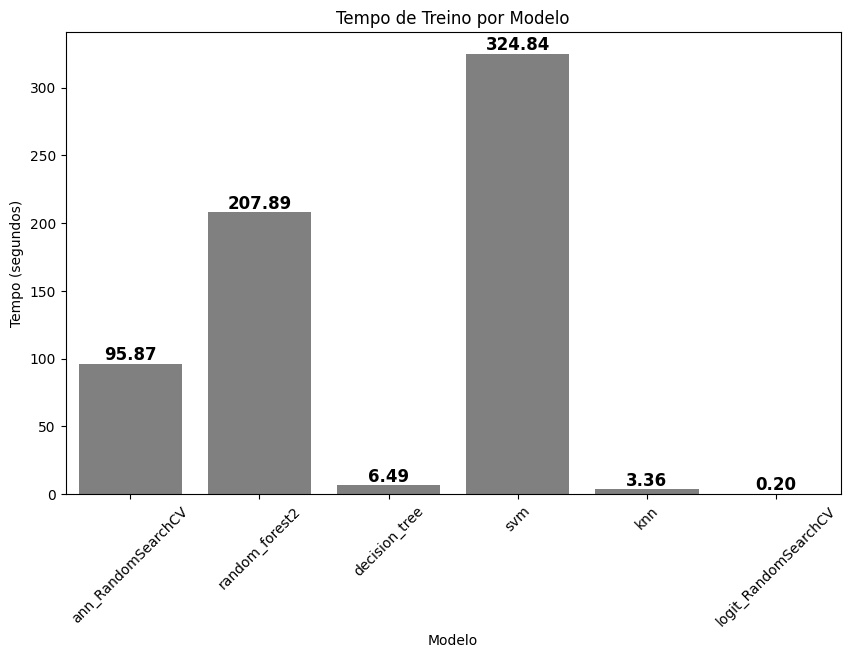

In [212]:
plot_training_time(resource_usage)

Embora a métrica ROC AUC seja uma referência útil para avaliar a capacidade dos modelos de distinguir entre classes positivas e negativas, não é suficiente para determinar o melhor modelo para o problema em questão. O ROC AUC fornece uma visão geral do desempenho do modelo em diferentes limiares de decisão, mas não considera os impactos reais das classificações corretas e incorretas no contexto do negócio.

Na prática, a escolha do modelo mais adequado deve considerar não apenas a sua capacidade discriminativa, mas também o custo associado às decisões tomadas com base nas previsões. Por exemplo, um modelo pode apresentar um valor elevado de ROC AUC, mas gerar um número excessivo de falsos positivos ou falsos negativos, o que pode ter implicações significativas consoante o problema em análise.

Dado que o custo de um falso negativo é de 2000€, enquanto o de um falso positivo é de 500€, a escolha do modelo deve centrar-se na otimização do custo total para o negócio, minimizando o impacto financeiro das previsões incorretas.

Por este motivo, procede-se agora a uma análise de custo de negócio baseada no threshold. Esta abordagem permite definir um limiar de decisão ótimo, ajustado às necessidades específicas do problema, equilibrando corretamente os benefícios e os custos associados a cada tipo de erro. Com esta análise, pretende-se garantir que a escolha do modelo não se baseia apenas na métrica estatística, mas sim no impacto real das previsões no contexto operacional.

A função business_cost calcula o custo total associado às previsões incorretas do modelo, 

In [213]:
def business_cost(false_positive, false_negative):
  return false_positive_cost*false_positive + false_negative_cost*false_negative

A função get_costs_per_thresholds tem como objetivo calcular o custo do negócio para diferentes valores de limiar na classificação, permitindo avaliar de que forma a alteração do threshold influencia os custos decorrentes de previsões incorretas do modelo.

In [214]:
def get_costs_per_thresholds(y_true, y_predict_proba, threshold_step=100):
  threshold_axis = []
  business_cost_axis= []
  for i in range(0,1001,threshold_step):
    true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_true, y_predict_proba*1000 >= i).ravel()
    current_cost = business_cost(false_positive, false_negative)
    threshold_axis.append(i)
    business_cost_axis.append(current_cost)
  return threshold_axis, business_cost_axis

O código tem como objetivo analisar o impacto do threshold no custo do negócio para diferentes modelos de machine learning, permitindo identificar o threshold ótimo para cada modelo com base na minimização do custo. Para isso, cria-se um dicionário chamado model_business_cost, onde serão armazenados os custos de negócio calculados para cada modelo ao longo de diferentes valores de threshold.

In [215]:
model_business_cost = defaultdict(list)

for model_index in range(len(grid_search_results)):  # Iterar sobre todos os modelos
    best_model = grid_search_results[model_index].best_estimator_

    # Verifica se o modelo tem predict_proba()
    if hasattr(best_model, "predict_proba"):
        y_scores = best_model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva
    else:
        # Se não tiver predict_proba, usa decision_function(), normalizando os valores entre 0 e 1
        y_raw_scores = best_model.decision_function(X_test)
        y_scores = (y_raw_scores - y_raw_scores.min()) / (y_raw_scores.max() - y_raw_scores.min())

    # Obtém os custos do negócio por threshold
    x_axis, y_axis = get_costs_per_thresholds(y_test, y_scores)

    # Guardar os resultados
    model_business_cost["model"] += [models_and_params[model_index][0]] * len(y_axis)
    model_business_cost["business_cost"] += y_axis
    model_business_cost["threshold"] += x_axis

# Criar DataFrame com os resultados
model_business_cost_df = pd.DataFrame.from_dict(model_business_cost)

In [216]:
model_business_cost_df

,model,business_cost,threshold
0,ann_RandomSearchCV,3651500,0
1,ann_RandomSearchCV,1434500,100
2,ann_RandomSearchCV,1253500,200
3,ann_RandomSearchCV,1305500,300
4,ann_RandomSearchCV,1376500,400
...,...,...,...
61,logit_RandomSearchCV,1840500,600
62,logit_RandomSearchCV,1870000,700
63,logit_RandomSearchCV,1870000,800
64,logit_RandomSearchCV,1870000,900


O código abaixo gera um gráfico de linhas que visualiza a relação entre o threshold e o custo do negócio para  os diferentes modelos de machine learning. Esta análise é fundamental para identificar qual o threshold ótimo que minimiza os custos operacionais.

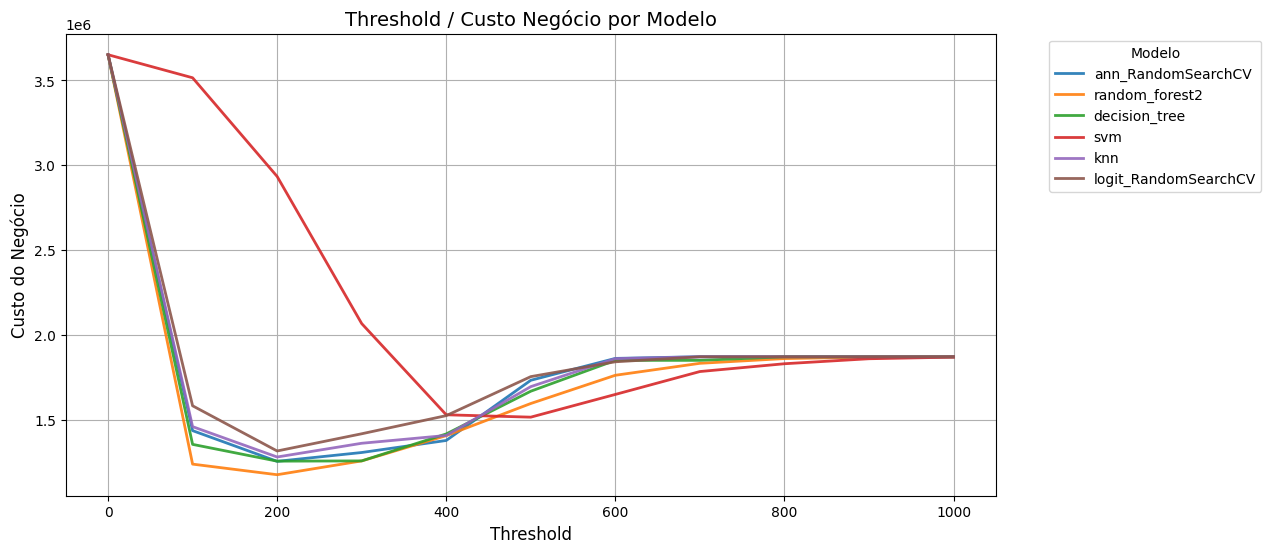

In [217]:
plt.figure(figsize=(12, 6))  # tamanho da figura

sns.lineplot(
    data=model_business_cost_df,
    x="threshold",
    y="business_cost",
    hue="model",
    linewidth=2,
    alpha=0.9     
)

plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Custo do Negócio", fontsize=12)
plt.title("Threshold / Custo Negócio por Modelo", fontsize=14)

plt.legend(title="Modelo", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True)

plt.show()  # Exibe o gráfico

O código apresentado identifica o threshold ótimo para os diferentes modelos ao encontrar o ponto em que o custo do negócio é mínimo. Para isso, a função .loc[] é utilizada para filtrar o DataFrame model_business_cost_df, selecionando apenas as linhas onde o valor da coluna "business_cost" é igual ao menor custo registado na tabela.

In [218]:
model_business_cost_df.loc[model_business_cost_df["business_cost"]==model_business_cost_df["business_cost"].min()]

,model,business_cost,threshold
13,random_forest2,1174500,200


Com base na análise dos modelos treinados e na avaliação dos custos associados, o modelo Random Forest (random_forest2) demonstrou ser a melhor escolha para otimizar os resultados de negócio. Este modelo apresentou o menor custo de negócio no conjunto de teste num theshold de 200, o que significa que tendo em contas os custos descritos e para tentar minimzar os mesmos, um cleinte deve ser considerado um bom candidato para campanha se a problabiliddade de contrair deposito do modelo for pelo menos 20%.


Após a análise dos resultados acima, o código seguinte tem como objetivo calcular métricas adicionais de desempenho para cada modelo que foi treinado e otimizado através do GridSearchCV, garantindo uma conclusão fundamentada.

Para esse efeito, são calculadas três métricas adicionais na avaliação dos modelos:

**Precisão (Precision Score)**: Mede a proporção de previsões positivas corretas em relação ao total de previsões positivas feitas pelo modelo. Dado que existe um custo de 500 euros por falso positivo, esta métrica é particularmente relevante. No entanto, a precisão, isoladamente, pode ser enganadora se não for analisada em conjunto com o recall.

**Recall**: Avalia a capacidade do modelo para identificar corretamente os casos positivos reais. Esta métrica é crucial para garantir que o modelo não exclui potenciais clientes interessados, minimizando o impacto dos falsos negativos.

**F1-Score**: Combina precisão e recall numa única métrica, equilibrando ambos os aspetos. Foi escolhida porque já foi identificado um desbalanceamento entre as classes, tornando o F1-Score uma métrica mais robusta na comparação dos modelos.

Os resultados de cada modelo são armazenados numa lista de dicionários (results), juntamente com o ROC AUC previamente calculado. Cada entrada contém o nome do modelo e os respetivos valores de precisão, recall, F1-score e ROC AUC, devidamente arredondados a quatro casas decimais.

In [219]:
# Lista para armazenar os resultados de cada modelo
results = []

# Iterar sobre os modelos em grid_search_results
for idx, grid_search in enumerate(grid_search_results):
    best_model = grid_search.best_estimator_  # Melhor modelo encontrado na GridSearchCV

    # Verificar se o modelo é um Pipeline
    if hasattr(best_model, "steps"):
        # Se for um Pipeline, extrai o nome do classificador final
        model_name = type(best_model.steps[-1][1]).__name__  # Último elemento do pipeline
    else:
        model_name = type(best_model).__name__  # Nome do modelo

    # Verifica se o modelo tem o método predict_proba
    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva
    else:
        # Se não tiver predict_proba (ex: SVC), usa decision_function(), mas precisa de normalização
        y_scores = best_model.decision_function(X_test)

        # Normalizar para valores entre 0 e 1 (usando min-max scaling)
        y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())

    # Determinar o melhor threshold para este modelo
    best_threshold_for_model = model_business_cost_df.loc[
        model_business_cost_df["business_cost"] == model_business_cost_df["business_cost"].min(),
        "threshold"
    ].values[0]

    # Previsões binárias com o melhor threshold
    y_pred = (y_proba * 1000 >= best_threshold_for_model).astype(int)

    # Calcular métricas
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Guardar os resultados
    results.append({
        "Modelo": model_name,  # Agora identifica corretamente o modelo
        "Precisão": round(precision, 4),
        "Recall": round(recall, 4),
        "F1-Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4)
    })

# Criar um DataFrame para visualizar os resultados
results_df = pd.DataFrame(results)
results_df

,Modelo,Precisão,Recall,F1-Score,ROC AUC
0,MLPClassifier,0.4355,0.4877,0.4601,0.7609
1,RandomForestClassifier,0.4245,0.5626,0.4839,0.7770
2,DecisionTreeClassifier,0.4370,0.4856,0.4600,0.7695
3,SVC,0.1306,0.8556,0.2266,0.6786
4,KNeighborsClassifier,0.4163,0.4866,0.4487,0.7567
5,LogisticRegression,0.4305,0.4439,0.4371,0.7492


O **RandomForestClassifier** é o modelo que melhor otimiza os custos do negócio, uma vez que apresenta um bom recall (0.5626), reduzindo o número de falsos negativos, que têm um custo elevado de 2000€. Além disso, possui uma precisão relativa aceitável (0.4245), evitando um número excessivo de falsos positivos, cujo custo é de 500€. O seu F1-score (0.4839) demonstra um equilíbrio entre recall e precisão, tornando-o uma escolha robusta para um cenário de classes desbalanceadas. Adicionalmente, o modelo regista o melhor ROC AUC (0.7770), o que indica uma boa capacidade de separação entre clientes que aderem e não aderem ao depósito a prazo. Por fim, a análise do custo em função do threshold confirma que o RandomForestClassifier é o modelo que minimiza o impacto financeiro das previsões incorretas, tornando-o a opção mais eficiente para o negócio

# 5. Qual/Quais as métricas de avaliação que usaram para comparar a performance dos vários modelos? Porquê?

---

Foram utilizadas várias métricas para comparar a performance dos modelos, tendo em conta o custo financeiro associado aos falsos positivos e falsos negativos, bem como o desbalanceamento das classes.

A **precisão (Precision Score)** foi considerada relevante, pois mede a proporção de previsões positivas corretas em relação ao total de previsões positivas feitas pelo modelo, sendo essencial para avaliar o impacto financeiro dos falsos positivos, que têm um custo de 500€.

No entanto, como o custo dos falsos negativos é ainda superior (2000€), a métrica de recall também foi analisada, pois mede a capacidade do modelo em identificar corretamente os casos positivos reais e evitar perdas significativas. 

Para equilibrar ambas as métricas, foi utilizado o **F1-score**, que combina **precisão e recall** numa única métrica, tornando-se especialmente relevante devido ao desbalanceamento das classes, onde apenas 4640 clientes aderiram ao depósito a prazo face a 36.548 que não aderiram. 

Além disso, foi considerada a área sob a curva ROC (ROC AUC), que mede a capacidade do modelo de distinguir entre clientes que aderem e não aderem ao depósito em diferentes thresholds, permitindo uma visão geral da qualidade da classificação. 

Para complementar a análise, foi realizada uma avaliação do custo do negócio em função do threshold, permitindo identificar o ponto ótimo onde o custo é minimizado. Assim, a escolha das métricas teve como objetivo equilibrar precisão e recall, minimizar o custo total do negócio e garantir que o modelo não fosse tendencioso para a classe maioritária.

Assim, o modelo Random Forest (random_forest2) foi selecionado como a melhor opção, pois combina um bom equilíbrio entre desempenho preditivo e impacto financeiro, garantindo uma solução mais eficiente para a tomada de decisão no banco.

# 6. Qual é o custo que o banco tem sem nenhum modelo?

Se o banco contactasse todos os clientes assumindo que todos iam contrair o de+psito, então todos os clientes que não aderissem seriam  Falsos Positivos (FP) e o banco teria um custo de 500€ por cada um deles.

In [220]:
cost1 = (y_test == 0).sum().sum()*false_positive_cost
print(f"O banco tem o custo actual (no conjunto de teste) de {cost1} €")

O banco tem o custo actual (no conjunto de teste) de 3651500 €


ou..

Se o banco não fizesse campanha para, teria um custo indireito (custo oportunidade implicito) (
clientes que iriam  aderir
)
×
2000 Falsos Negativos (FN)

In [221]:
cost2 = y_test.sum()*false_negative_cost
print(f"O banco tem o custo actual (no conjunto de teste) de {cost2}€")

O banco tem o custo actual (no conjunto de teste) de 1870000€


Como a classe está fortemente desbalanceada para o valor zero, apesar de um falso positivo ter um custo inferior a um falso negativo, a sua elevada frequência faz com que, em termos proporcionais, o impacto financeiro seja significativo. Assim, na ausência de um modelo preditivo, o banco perderia menos dinheiro ao optar por não avançar com nenhuma campanha de marketing, a solução ideal passa por utilizar um modelo preditivo para segmentar os clientes corretamente e reduzir os custos da campanha!

# 7. Qual o custo que o banco passa a ter com o vosso modelo?

In [222]:
test_set_business_cost = model_business_cost_df["business_cost"].min()
print(f"Com este modelo, o banco tem o custo (no conjunto de teste) de {test_set_business_cost}€")
print(f"Este custo representa uma diferença absoluta de {cost1 - test_set_business_cost}€, e uma redução de custos em {round( 1 - (test_set_business_cost/(cost1)),3)*100}%")

Com este modelo, o banco tem o custo (no conjunto de teste) de 1174500€
Este custo representa uma diferença absoluta de 2477000€, e uma redução de custos em 67.80000000000001%
